<font face="Time New Roman" size=12 color=#A52A2A >
PHYS20762 Computational Physics
    <br>
    <font face="Time New Roman" size=7 color=black >
        <br>
        Numerical Integration
        <font face="Time New Roman" size=5 color=black >
    <br>
Pan Zhang
    <font face="Time New Roman" size=5 color=black >
    <br>
University of Manchester
    <br>
March 2022



<font face="Time New Roman" size=5 color=black >
1. Introduction

There are many ways to describe the Physics model. Some of the Physics models cannot be expressed as mathematical functions, but need to be described by a differential equation. In the past two years, we have already learned the analytical solutions of basic differential equations. We also learned the solution of some special differential equations, such as the Bessel equation, Legendre equation, and Hermite equation;  they are solvable by assuming the solutions are polynomials. While encountering some more complicated differential equations, we no longer have an analytical solution. With the support of computers, we can solve them numerically.
In this project, we focus on using a numerical method to solve the differential equation, specifically, solve the differential equation that describes the spring-mass system:
                           $$m\ddot{x}(t)+b\dot{x}(t)+kx(t) = F(t)$$ 
where m is the mass of the object attached to the spring, b is the damp constant, k is the spring constant, F is the external force applied to the object, and x is the displacement. Then, we apply this numerical integration method to solve more physics models, such as the quantum simple harmonic oscillator.

In [192]:
# import the library 
import sys

import numpy as np
import numpy.polynomial.hermite as Hermite

from scipy.optimize import curve_fit
from scipy import constants
from scipy.signal import find_peaks
from scipy import special

import math
from math import factorial
import cmath

import matplotlib.pyplot as plt

First of all, let's define the constant of the differential equation. Those constant affect the behavior of the spring oscillation. The name of constants follows the Physics convention.

In [193]:
# Choose some physics parameters
M = 5.21 #in kg
K = 2 #in kg/s^2
B = 0.2 #in kg/s
# Choose how long we are integrating for (in s)
T = 300
# Choose the step size (in s)
STEP_SIZE = 0.1

#Define the initial position of the mass
X_0 = 0
V_0 = -1

Spring-mass system can be described as a homogeneous, second-order, linear differential equation.
$$m\ddot{x}(t)+b\dot{x}(t)+kx(t) = 0        $$
Suppose the solution is $$x = Ke^{\lambda t}$$
We substitute this solution into the differential equation and cross off the same term:
$$ {\lambda^2 m} + {\lambda b} + k = 0        $$
The root is:
$$ \lambda = \frac{-b \pm \sqrt{b^2-4m\,k}}{2m}. $$
Define $\displaystyle{\gamma=\frac{b}{m}}$, $\displaystyle{\omega_0^2=\frac{k}{m}}$

and rewrite the root:
$$\lambda = -\frac{\gamma}{2} \pm \sqrt{\frac{\gamma^2}{4} - \omega_0^2}$$

If two roots are real and distinct, the solution represents a heavy damped system:
$$	x(t)=e^{-\frac{\gamma}{2} t} ( A e^{\displaystyle{\sqrt{\frac{\gamma^2}{4} - \omega_0^2}}t} + B e^{\displaystyle{-\sqrt{\frac{\gamma^2}{4} - \omega_0^2} }t})$$

If two roots are complex, the spring mass system is a light damping system:
$$\begin{eqnarray*} 
	x(t) = e^{-\frac{\gamma}{2}t} (A' \cos\displaystyle{\sqrt{\omega_0^2 - \frac{\gamma^2}{4}}}t + B' \sin \displaystyle{\sqrt{\omega_0^2 - \frac{\gamma^2}{4}}} t), 
	\end{eqnarray*}$$

In order to simplify the analytic solution, we define the frequency of the system as $$\displaystyle{\omega^2 = \omega_0^2 - \frac{\gamma^2}{4}}$$
The solution is then rewrite as 	

$$\begin{eqnarray*}
	x(t) &=& e^{-\frac{\gamma}{2}t} (A e^{i\displaystyle{\sqrt{\omega_0^2 - \frac{\gamma^2}{4}}}t} + B e^{-i\displaystyle{\sqrt{\omega_0^2 - \frac{\gamma^2}{4}}}t} )\\
	&=& e^{-\frac{\gamma}{2}t} (A e^{i\omega t} + B e^{-i\omega t})
\end{eqnarray*}$$

This is the solution for heavy damping system and light damping system. To eliminate the constant A and B, we can bring in the initial condition of position and velocity. Then the constant A is equal to $$A = \frac{v_{0}+x_{0}b}{2i\sqrt{4km-b^2}} B = x_{0} - A$$

The math is coded in the "analytical solution" function.

In [194]:
def analyticalSolution(time, x0=X_0, v0=V_0, step_size=STEP_SIZE, m=M, k=K, b=B):
    """
    A function calculates the numerical solution of spring mass oscillation analytically.
    

    Parameters
    ----------
    time : array, time array has the step size
    
    x0 : int, optional
        initial displacement of the mass. The default is X_0.
        
    v0 : int, optional
        initial displacement of the velocity. The default is V_0.
    step_size : TYPE, optional
        the step_size of the time array. another word, the time interval
    m : mass, optional
        the object mass. The default is M.
    k : int, optional
        the spring constant. The default is K.
    b : int, optional
        the damping constant. The default is B.

    Returns
    -------
    x displacement array
    v velocity array

    """
    #Express A and B constants
    A = (b / (2 * 1j * cmath.sqrt(4 * k * m - b ** 2)) + 1 / 2) * x0 + v0 * m / (
        cmath.sqrt(4 * k * m - b ** 2) * 1j
    )
    B = x0 - A
    
    #The term helps simplify the equation
    #𝛾
    gamma = b / m  
    #𝜔 frequency
    omega = (
        (k / m) - (gamma ** 2 / 4)
    ) ** 0.5  
    
    # consider the critical damping
    if (gamma ** 2 / 4) == (k / m):  
        x = np.exp(-(gamma * time / 2)) * (A + (B * time))
        # get the velocity
        v = (-gamma / 2) * x + (np.exp(-(gamma * time / 2)) * B)
        
    else:  #else the system is either heavily damped or light damped
        x = np.exp(-(gamma * time / 2)) * (
            A * np.exp(1j * omega * time) + B * np.exp(-1j * omega * time)
        )
        v = (-gamma / 2) * x + (
            np.exp(-(gamma * time / 2))
            * (
                A * 1j * omega * np.exp(1j * omega * time)
                - B * 1j * omega * np.exp(-1j * omega * time)
            )
        )
    
    x_array = np.real(x)  # Converting the physical quantities to real numbers
    v_array = np.real(v)

    return x_array, v_array


We define the plot funciton at the beginning of the report to avoid the repeatability and bug of code. 

In [195]:
def plot(
    x_array,
    y_array,
    plot_name,
    x_label,
    y_label,
    title,
    multimethod=True,
    compare=False,
    mark_x=False,
    xMax=False
):
    """
    The main plot function. It can plot three types of function which should
    be enough in this project.
    1. Plot a single function
    set multimethod = False
    2. Plot a compare plot function
    set multimethod = True
    set compare = True
    3. plot a multiple function
    
    set multimethod = True
    set compare = False

    Parameters
    ----------
    x_array : array
        the x axis values
    y_array : array
        the y axis values
    plot_name : string "string" for single function
                or array contain string has the form["string","string"]
                The legend of the plot

    x_label : string "string" for single function
                or array contain string has the form["string","string"]
                
                The description of x axis
    y_label : string "string" for single function
                or array contain string has the form["string","string"]
                
                The description of y axis
    title : string
    the name of the plot
    
    multimethod : bool, optional
    switch
    
    compare : bool, optional
        switch. The default is False.
        
    mark_x : bool, optional
        mark a x point. The default is False.
    xlim : bool, optional
        set a plot range of x
        
    Returns
    -------
    None.

    """
    x_max = np.amax(x_array)
    try:
        fig = plt.figure(figsize=(10, 8))
        main_plot = fig.add_subplot(111)
        main_plot.set_title(title, fontsize="17")
        if multimethod:
            if not compare:
                main_plot.set_xlabel(x_label, fontsize="15")
                main_plot.set_ylabel(y_label, fontsize="15")
                for i in range(len(x_array)):
                    main_plot.plot(x_array[i], y_array[i])
                plt.legend(plot_name)
            if compare:
                main_plot.set_xlabel(x_label, fontsize="15")
                main_plot.set_ylabel(y_label, fontsize="15")
                main_plot.plot(x_array[0], y_array[0])
                main_plot.plot(x_array[1], y_array[1], "k--")
                plt.legend(plot_name)
        if not multimethod:
            main_plot.plot(x_array, y_array)
            main_plot.set_xlabel(x_label, fontsize="15")
            main_plot.set_ylabel(y_label, fontsize="15")
            plt.legend(plot_name)
        if isinstance(mark_x, float):
            plt.axvline(x=mark_x, color="k", ls="--")
        if isinstance(xMax, float):
            plt.xlim(0, xMax)
        plt.show()
        return None
    except TypeError:
        print("Encounter Type error for some reason")
        sys.exit()
    except ValueError:
        print("encounter Value Error for some reason")
        sys.exit()


Recall that we have three different types of oscillation. 
The spring-mass system has no oscillation when it is heavily damped.
$$\displaystyle{\frac{\gamma^2}{4} > \omega_0^2}$$
The spring mass system is light damped if
$$\displaystyle{\frac{\gamma^2}{4} < \omega_0^2}$$
For critical damping system
$$\displaystyle{\frac{\gamma^2}{4} = \omega_0^2}$$

The graph of heavy damp and critical damp is similar. However, you still can identify them because the displacement curve of critical damping should present a inflection point due to $\displaystyle{\frac{\gamma^2}{4} = \omega_0^2}$.

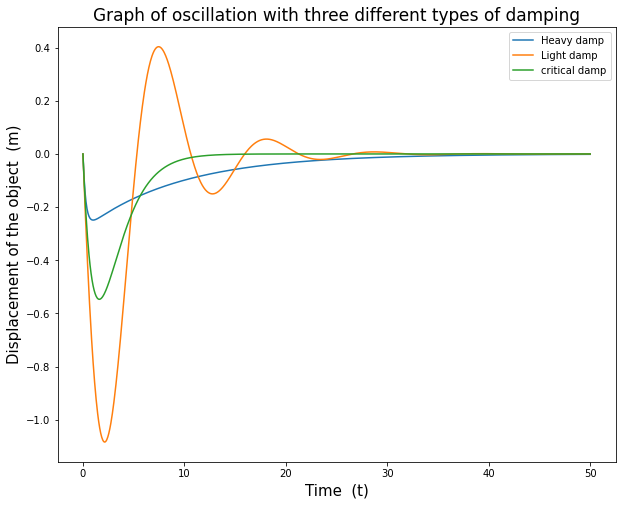

In [196]:
b_critical = 2 * (M * K) ** 0.5
time = np.linspace(0, 50, 1000)
displacement_heavy_damped, _ = analyticalSolution(time, b=b_critical * 3)
displacement_light_damped, _ = analyticalSolution(time, b=0.3 * b_critical)
displacement_critical, _ = analyticalSolution(time, b=b_critical)
X_ARRAY = [time, time, time]
Y_ARRAY = [displacement_heavy_damped, displacement_light_damped, displacement_critical]
PLOT_NAME = ["Heavy damp", "Light damp", "critical damp"]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "Time  (t)",
    "Displacement of the object  (m)",
    "Graph of oscillation with three different types of damping"
)


<font face="Time New Roman" size=5 color=black >
2.  Numerical method for spring-mass system


We define a function to generate displacement, velocity, and time in the form of an array based on the object's initial position, velocity, step size, and time range.

In [197]:
def position_velocity_time_array(x_0=X_0, v_0=V_0, step_size=STEP_SIZE, t=T):
    """
    Generate position, time, velocity array based on the initial condition of
    position, velocity, time step size and time period.

    Parameters
    ----------
    x_0 : float, optional
        initial condition of position. The default is X_0.
    v_0 : float, optional
        initial condition of velocity. The default is V_0.
    step_size : float, optional
        step size. The default is STEP_SIZE.
    t : float, optional
        time period. The default is T.

    Returns
    -------
    x_array : array
        position array
    v_array : array
        velocity array.
    nsteps : int
        number of steps
    time_array : array
        array of time

    """
    nsteps = int(round(t / step_size))
    x_array = np.zeros(nsteps)
    v_array = np.zeros(nsteps)
    x_array[0] = x_0
    v_array[0] = v_0
    time_array = np.arange(0, T, step_size)
    return x_array, v_array, nsteps, time_array


<font face="Time New Roman" size=2 color=black >
We have already seen the solution of the spring-mass system with the analytical method. However, the analytical method is not always the best choice when differential equation becomes more complicated and vague, and the numerical method plays an important role in this situation.

Let's look at the Euler method first.
For a spring-mass system, displacement, velocity, and acceleration follows the relationship below:
    $$a_{i} = -\frac{k}{m}x_{i} - \frac{b}{m}v_{i}$$
Therefore, we know velocity from acceleration:
    $$v_{i+1} = v_{i} + time step * a_{i}$$
and finally, we know displacement from velocity:
    $$x_{i+1} = x_{i} + time step * v_{i}$$
Its time step is infinitesimal so that the x can be taylor expanded as 
    $$x(t+h) = x(t) + timestep*\dot{x}(t) + \frac{1}{2} timestep^2*\ddot{x}(t) $$
We calculate the velocity by taking the derivative of displacement with respect to time.
    $$v(t) = \dot{x}(t) = \frac{x(t+h) - x(t)}{timestep} + \frac{1}{2} timestep *\ddot{x}(t) $$
    The error of the velocity is: $$\frac{1}{2} timestep * \ddot{x}(t)$$ which is treated as the Euler method's truncation error. The error is in the first order of the time step size so the Euler method error is very large.

In [198]:
def Euler(x_0=X_0, v_0=V_0, step_size=STEP_SIZE, m=M, k=K, b=B, t=T):
    """
    Numerical integration
    Euler method
    all of the letter follows the convention of Physics
    Parameters
    ----------
    x_0 : int, optional
        the initial displacement of the mass. The default is X_0.
    v_0 : int, optional
        the initial displacement of the mass. The default is V_0.
    step_size : float, optional
        the step size of the numerical integration. The default is STEP_SIZE.
    m : float, optional
        The mass of the object. Unit in kg  The default is M.
    k : float, optional
        The spring constant of the object. Unit in N/m. The default is K.
    b : float, optional
        The damping constant of the spring. unit in kg/s. The default is B.
    t : int, optional
        Time in s. The default is T.
    
    Returns
    -------
    x : array
        displacement array of the mass
    v : array
        displacement array of the mass.
    nsteps : int
        the number of subdivision of the time.
    x_LocalError: list
        the error of Euler method of each step
    X_GloabalError: list
        the accumulated error of position

    """
    # calculate the error correpsond to each steps
    x_LocalError = [0]
    # calcualte the accumulated error to the last steps
    x_GlobalError = [0]
    x, v, nsteps, time = position_velocity_time_array(x_0, v_0, step_size)
    #Euler method
    for i in range(nsteps - 1):
        a = -(k / m) * x[i] - (b / m) * v[i]
        x[i + 1] = x[i] + step_size * v[i]
        v[i + 1] = v[i] + step_size * a
        x_LocalError.append(abs(0.5 * step_size ** 2 * a))
        x_GlobalError.append(x_GlobalError[-1] + x_LocalError[i + 1])
    return x, v, nsteps, x_LocalError, x_GlobalError


To improve the Euler method, we simply Tayler expand one more term
$$x_{t+h} = x(t) + h\dot{x}(t) + \frac{1}{2}t^2\ddot{x}(t) + \frac{1}{3!}t^3\dddot{x}(t) $$
and the algorithm becomes:
$$a_{i} = -\frac{k}{m}x_{i} - \frac{b}{m}v_{i}$$
$$v_{i+1} = v_{i} + time step * a_{i}$$
$$x_{i+1} = x_{i} + time step * v_{i} + \frac{1}{2}timestep^2*a_{i}$$
Analogically, the error of the improved Euler method is just
$$error = \frac{1}{3!}h^3\dddot{x}(t)$$
To compute the third derivative of the displacement, we can calculate the derivative of acceleration to time.$$\dddot{x} = \frac{a_{i+1}-a_{i}}{step}$$
Noting that this term still has a physical meaning, it is meaningless to take the second derivative and higher-order derivative of the acceleration.

In [199]:
def Improved_Euler(x_0=X_0, v_0=V_0, step_size=STEP_SIZE, m=M, k=K, b=B, t=T):
    """
    Numerical integration
    Improved Euler method
    all of the letter follows the convention of Physics
    Parameters
    ----------
    x_0 : int, optional
        the initial displacement of the mass. The default is X_0.
    v_0 : int, optional
        the initial displacement of the mass. The default is V_0.
    step_size : float, optional
        the step size of the numerical integration. The default is STEP_SIZE.
    m : float, optional
        The mass of the object. Unit in kg  The default is M.
    k : float, optional
        The spring constant of the object. Unit in N/m. The default is K.
    b : float, optional
        The damping constant of the spring. unit in kg/s. The default is B.
    t : int, optional
        Time in s. The default is T.

    Returns
    -------
    x : array
        displacement array of the mass
    v : array
        displacement array of the mass.
    nsteps : int
        the number of subdivision of the time.
    x_LocalError: list
        the error of Euler method of each step
    X_GloabalError: list
        the accumulated error of position

    """
    # calculate the error correpsond to each steps
    x_LocalError = [0]
    # calcualte the accumulated error to the last steps
    x_GlobalError = [0]
    a_list = []
    x, v, nsteps, time = position_velocity_time_array(step_size=step_size)
    #Improved Euler method
    for i in range(nsteps - 1):
        a = -k / m * x[i] - b / m * v[i]
        a_list.append(a)
        x[i + 1] = x[i] + step_size * v[i] + 1 / 2 * step_size ** 2 * a
        v[i + 1] = v[i] + step_size * a
    # calculate one extra acceleration in order to compute the third order derivative of displacement
    a_list.append(-k / m * x[-1] - b / m * v[-1])
    for i in range(nsteps - 1):
        x_third_derivative = abs((a_list[i + 1] - a_list[i]) / step_size)
        x_LocalError.append(1 / 6 * x_third_derivative * step_size ** 3)
        x_GlobalError.append(x_GlobalError[-1] + x_LocalError[i + 1])
    return x, v, nsteps, x_LocalError, x_GlobalError


<font face="Time New Roman" size=2 color=black >
Euler method and Improved Euler method used the idea of left Riemann sum which brings inaccuracy to the function when its first derivative is negative. The Verlet method solves this problem by using the middle Riemann sum, it is equivalent to the central derivative. Verlet method is non-self-starting.
    $$\dot{x}(t) = \lim_{h \to 0}\frac{x(t+h)-x(t-h)}{2h}$$
Taylor expand the displacement function:
    $$x_{t+h} = x(t) + h\dot{x}(t) + \frac{1}{2}t^2\ddot{x}(t) + \frac{1}{3!}t^3\dddot{x}(t) $$
    $$x_{t-h} = x(t) - h\dot{x}(t) + \frac{1}{2}t^2\ddot{x}(t) - \frac{1}{3!}t^3\dddot{x}(t) $$
After some algebra, the velocity and acceleration can be expressed as the displacement function
    $$\dot{x}(t) = \frac{x(t+h)-x(t-h)}{2h} + \frac{1}{3!}t^2\dddot{x}(t)$$
    $$\ddot{x}(t) = \frac{x(t+h)+x(t-h)-2x(t)}{2h} - \frac{2}{4!}t^2\ddddot{x}(t)$$
with error $$\frac{1}{3!}t^2\dddot{x}(t)$$ and $$\frac{2}{4!}t^2\ddddot{x}(t)$$ respectively.

After more algebra, the equation above is simplified as
    $$x_{i+1} = Ax_{i} + Bx_{i-1}$$
where $$A = 2\frac{2m-kh^2}{D},B = \frac{bh-2m}{D} and D = 2m+bh$$
The error of the displacement is in the fourth-order of the time steps. It is much more accurate than the Euler method and the Improved Euler Method. Therefore, it is unnecessary to calculate the truncation error in each step. The fourth derivative of the displacement is also physically meaningless. At the same time, we might need to consider the floating-point error when calculating the fourth-order error. Therefore, we will use another method to study the Verlet method error later.

<br>
Now, I choose to call improved Euler to start the Verlet method.

In [200]:
def Verlet(x_0=X_0, v_0=V_0, step_size=STEP_SIZE, m=M, k=K, b=B, t=T):
    """
    Numerical integration
    Euler method
    all of the letter follows the convention of Physics
    Parameters
    ----------
    x_0 : int, optional
        the initial displacement of the mass. The default is X_0.
    v_0 : int, optional
        the initial displacement of the mass. The default is V_0.
    step_size : float, optional
        the step size of the numerical integration. The default is STEP_SIZE.
    m : float, optional
        The mass of the object. Unit in kg  The default is M.
    k : float, optional
        The spring constant of the object. Unit in N/m. The default is K.
    b : float, optional
        The damping constant of the spring. unit in kg/s. The default is B.
    t : int, optional
        Time in s. The default is T.

    Returns
    -------
    x : array
        displacement array of the mass
    v : array
        displacement array of the mass.
    nsteps : int
        the number of subdivision of the time.

    """
    #call improved euler method to start
    displacement_start, velocity_start, nsteps, _, _ = Improved_Euler(
        x_0, v_0, step_size, m, k, b, t
    )
    x, v, nsteps, time = position_velocity_time_array(x_0, v_0, step_size)
    x[1] = displacement_start[1]
    v[1] = velocity_start[1]
    
    #Verlet method
    D = 2 * m + b * step_size
    A = 2 * (2 * m - k * step_size ** 2) / D
    B = (b * step_size - 2 * m) / D
    for i in range(1, nsteps - 1):
        x[i + 1] = A * x[i] + B * x[i - 1]
        v[i] = (x[i + 1] - x[i - 1]) / (2 * step_size)
    return x, v, nsteps


The Euler-Cromer method is a symplectic integrator. The symplectic method is good for simulating the energy conserved system. In our case, the spring-mass system is an energy conserved system so we expect the Euler-Cromer method to show good accuracy. Another reason why the Verlet method is accurate is that the Verlet method is a symplectic integrator as well!
The way to implement this method is simply change the Euler's method velocity term of displacement expression $v_{i}$ into $v_{i+1}$.

The algorithm is:
    $$a_{i} = -\frac{k}{m}x_{i} - \frac{b}{m}v_{i}$$
    $$v_{i+1} = v_{i} + time step * a_{i}$$
    $$x_{i+1} = x_{i} + time step * v_{i+1}$$

In [201]:
def EulerCromer(x_0=X_0, v_0=V_0, step_size=STEP_SIZE, m=M, k=K, b=B, t=T):
    """
    Numerical integration
    Euler method
    all of the letter follows the convention of Physics
    Parameters
    ----------
    x_0 : int, optional
        the initial displacement of the mass. The default is X_0.
    v_0 : int, optional
        the initial displacement of the mass. The default is V_0.
    step_size : float, optional
        the step size of the numerical integration. The default is STEP_SIZE.
    m : float, optional
        The mass of the object. Unit in kg  The default is M.
    k : float, optional
        The spring constant of the object. Unit in N/m. The default is K.
    b : float, optional
        The damping constant of the spring. unit in kg/s. The default is B.
    t : int, optional
        Time in s. The default is T.

    Returns
    -------
    x : array
        displacement array of the mass
    v : array
        displacement array of the mass.
    nsteps : int
        the number of subdivision of the time.

    """
    x, v, nsteps, time = position_velocity_time_array(step_size=step_size)
    for i in range(nsteps - 1):
        a = -k / m * x[i] - b / m * v[i]
        v[i + 1] = v[i] + a * step_size
        x[i + 1] = x[i] + step_size * v[i + 1]
    return x, v, nsteps


We plot four methods together to show their difference. Then, we plot four methods separately and compare them with their analytic solution.

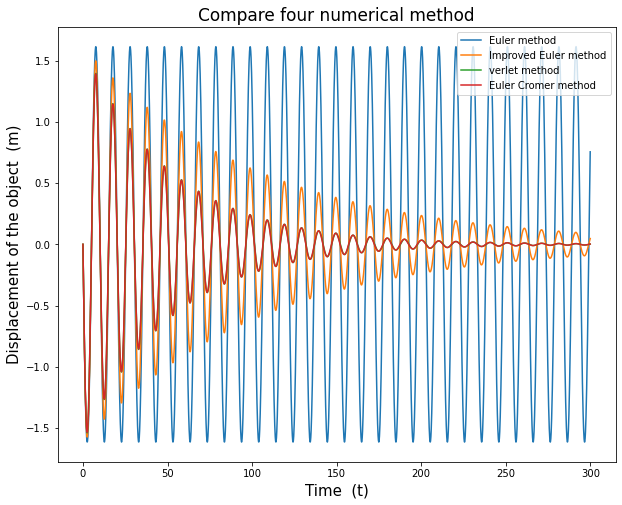

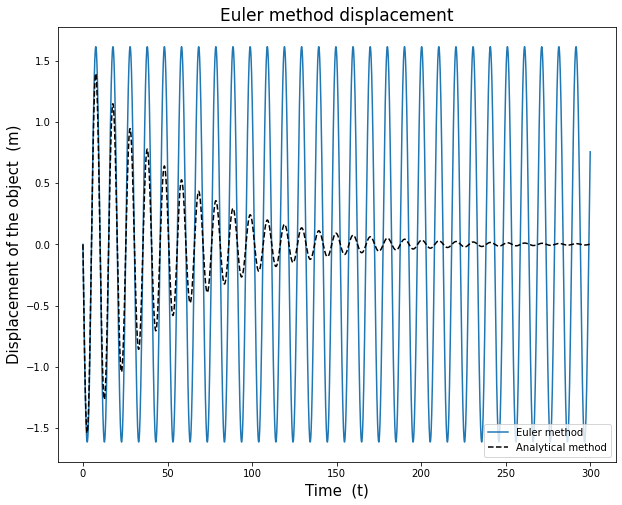

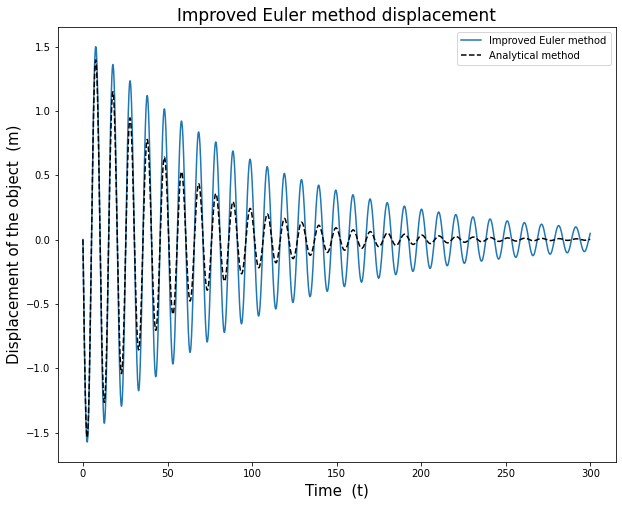

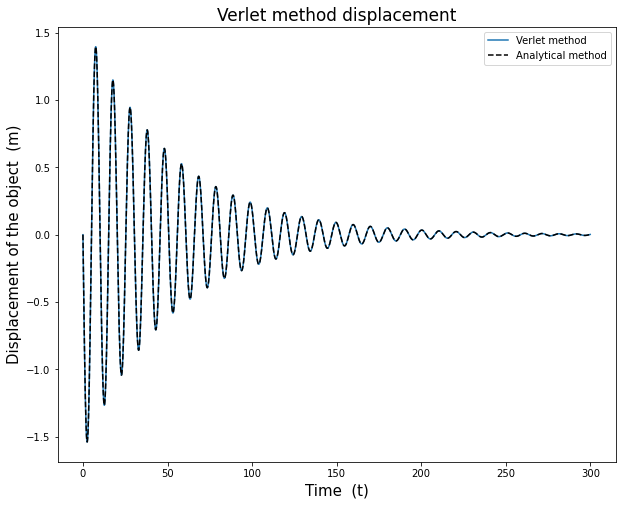

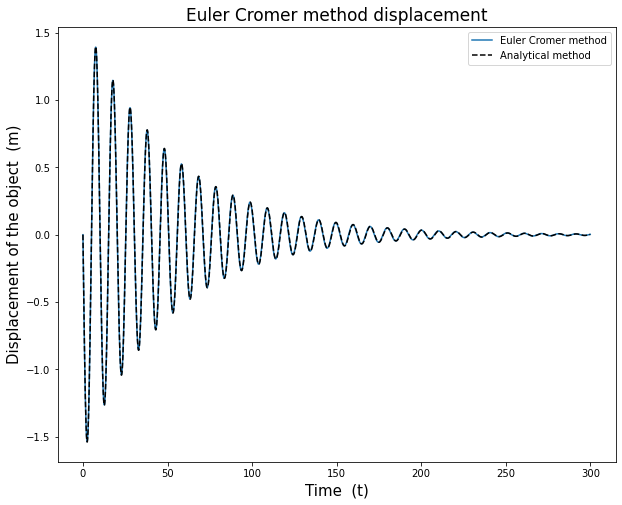

In [202]:
#####################################################
"step into the main program"
#####################################################

# Call 'position velocity time array' function to obtain a consistent position and time array.

x_ArrayEmpty, v_ArrayEmpty, nsteps, t_array = position_velocity_time_array()

# call four function to get solution
Euler_displacement, Euler_velocity, _, _, _ = Euler()
Improved_Euler_displacement, Improved_Euler_velocity, _, _, _ = Improved_Euler()
Verlet_displacement, Verlet_velocity, _ = Verlet()
EulerCromer_displacement, EulerCromer_velocity, _ = EulerCromer()

# Call analytic solution
displacement, velocity = analyticalSolution(t_array)

# call plot function to generate plot
X_ARRAY = [t_array, t_array, t_array, t_array]
Y_ARRAY = [
    Euler_displacement,
    Improved_Euler_displacement,
    Verlet_displacement,
    EulerCromer_displacement,
]
PLOT_NAME = [
    "Euler method",
    "Improved Euler method",
    "verlet method",
    "Euler Cromer method"
]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "Time  (t)",
    "Displacement of the object  (m)",
    "Compare four numerical method"
)

# setting up four groups
X_ARRAY = [t_array, t_array]
Y_ARRAY = [
    [Euler_displacement, displacement],
    [Improved_Euler_displacement, displacement],
    [Verlet_displacement, displacement],
    [EulerCromer_displacement, displacement]
]
PLOT_NAME = [
    ["Euler method", "Analytical method"],
    ["Improved Euler method", "Analytical method"],
    ["Verlet method", "Analytical method"],
    ["Euler Cromer method", "Analytical method"]
]
PLOT_TITLE = [
    "Euler method displacement",
    "Improved Euler method displacement",
    "Verlet method displacement",
    "Euler Cromer method displacement"
]

# Euler method vs. Analytical solution
for i in range(len(PLOT_NAME)):
    plot(
        X_ARRAY,
        Y_ARRAY[i],
        PLOT_NAME[i],
        "Time  (t)",
        "Displacement of the object  (m)",
        PLOT_TITLE[i],
        compare=True
    )




In [203]:
print("Our step size is:" , STEP_SIZE, 's')

Our step size is: 0.1 s


We can see that the solutions of the Verlet method and Euler Cromer method are very consistent with the analytical solution. 

The displacement plot of Improved Euler method shows a large deviation compared with its analytical solution. Euler method even cannot give a correct result with 0.1 step size, which indicates that the global truncation error is too large. The energy loss of the oscillation thus becomes less significant compared with the error of Euler method.

From the above plot, we understand the importance of reducing the truncation error in numerical integration. According to the theory, the numerical integration error directly relates to the step size. Although we could reduce the error by choosing a small step size, it would take lots of time to complete the calculation. Therefore, we need to find out which method provides the highest accuracy with the lowest time cost.

<font face="Time New Roman" size=5 color=black >
3. Investigate the effect of step size of each method


From the above theory, we know that the step size affect the accuracy of numerical integration. To show the relationship between step size and numerical integration error, we compare the numerical energy with analytical energy. The way to compare them is by looking at their percentage population standard deviation:
$$\sigma = \frac{1}{n}\sum_{i=0}^{n}\frac{|(E_m)_i - (E_a)_i|}{(E_m)_i}$$
n is the number of steps. $E_m$ is the energy calculated by the four numerical methods while $E_a$ is the one calculated by the analytical method.
<br>
This standard deviation reflects the sum of difference between analytical method and numerical method. We are able to plot a graph of standard deviation against step size. let's code the energy and standard deviation as a function first.

In [204]:
def energy(x, v, m=M, k=K):
    """
    

    Parameters
    ----------
    x : float,int or array
    v : float, int, or array
    m : int, optional
    k : int, optional
    Returns
    -------
    int or array
        return the total energy of the system

    """
    return 0.5 * k * (x ** 2) + 0.5 * m * (v ** 2)


def percentage_uncertianty_array(function):
    """
    calculate the error at each step and return them in percentage.
    

    Parameters
    ----------
    function:  A numerical method function.

    Returns
    -------
    steps : Array
        
        the integration steps. We can assign the meaning to the steps.
        In this case, it is time with the unit second. Therefore, we could
        say the steps has unit 0.1.
            
            
    percentage_uncertianty_array : Array
    
        calculate the error of each steps and sum all of error up to the last
        step

    """
    ###########
    "Set up the array"
    ###########
    # create a step array. We obtain a array that contain step size from 0.001 to 0.1 with 100 equal subdivision.
    steps = np.linspace(0.001, 0.1, 100)

    # calculate the number of steps. np.round and astype method is used to convert all float unmber into int.
    nsteps_array = np.round(T / steps)
    nsteps_array = nsteps_array.astype(int)

    # generate an empty array to contain the uncertainty. Its length is equal to the nsteps_array
    percentage_uncertianty_array = np.zeros(len(nsteps_array))

    ######################
    "main iteration procedure"
    ######################

    for i in range(len(percentage_uncertianty_array)):
        # get position array and velocity array numerically.
        # The Euler method and improved Euler method return their truncation error, we need to distinguish them with the Verlet
        # method and Euler Cromer method.
        try:
            x, v, nsteps = function(step_size=steps[i])
        except ValueError:
            x, v, nsteps, _, _ = function(step_size=steps[i])
        _, _, _, time_array = position_velocity_time_array(step_size=steps[i])
        time_array = np.linspace(0, T, nsteps_array[i])
        # get position array and velocity array analytically.
        x_analytic, v_analytic = analyticalSolution(time_array)

        # calculate the percentage error with the formula above
        percentage_uncertianty_array[i] = np.sum(
            np.abs(energy(x, v) - energy(x_analytic, v_analytic)) / energy(x, v)
        ) / (len(energy(x, v)))
    ###########
    # end loop
    ###########
    return steps, percentage_uncertianty_array


In [205]:
# Calculate the energy error

eulerSteps_Array, eulerUncertianty_Array = percentage_uncertianty_array(Euler)
improvedEulerSteps_Array, improvedEulerUnvertianty_Array = percentage_uncertianty_array(
    Improved_Euler
)
verletSteps_Array, verletUncertianty_Array = percentage_uncertianty_array(Verlet)
eulerCromerSteps_Array, eulerCromerUncertianty_Array = percentage_uncertianty_array(
    EulerCromer
)


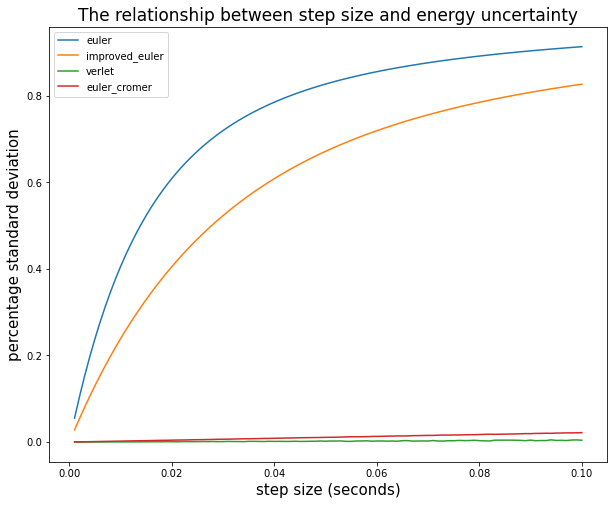

In [207]:
#####################################
"Plot"
#####################################
METHOD_NAME = ["euler", "improved_euler", "verlet", "euler_cromer"]

# array([euler, type:array, improved euler, type: array, verlet, type:array, euler_cromer, type:array])
# [array, array, array, array]
X_ARRAY = [
    eulerSteps_Array,
    improvedEulerSteps_Array,
    verletSteps_Array,
    eulerCromerSteps_Array
]
Y_ARRAY = [
    eulerUncertianty_Array,
    improvedEulerUnvertianty_Array,
    verletUncertianty_Array,
    eulerCromerUncertianty_Array
]
plot(
    X_ARRAY,
    Y_ARRAY,
    METHOD_NAME,
    "step size (seconds)",
    "percentage standard deviation",
    "The relationship between step size and energy uncertainty"
)


From the graph, the Verlet method shows the lowest percentage standard deviation. The Euler-Cromer method error is slightly higher than the error of the Verlet method. 

The error of the Euler method and the Improved Euler method shows a quick growth even at relatively low step size, which indicates their high global truncation error. The Verlet method is the most accurate numerical integration method among these four methods.

We can calculate the percentage error of the Verlet method with the step size that we use in this project, 0.1 seconds, and also can look at the truncation error of the Euler method and improved Euler method.

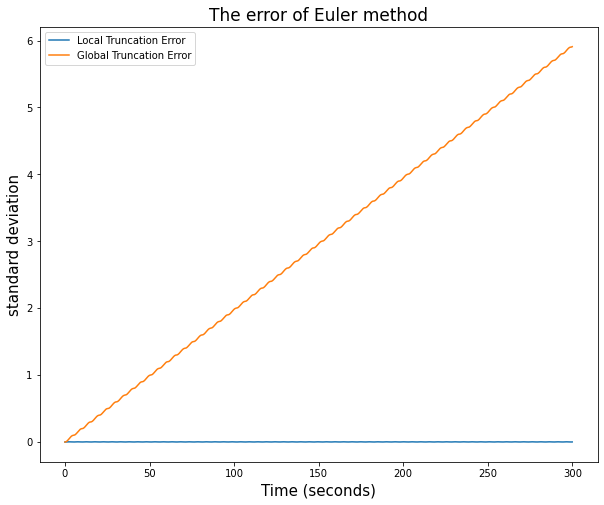

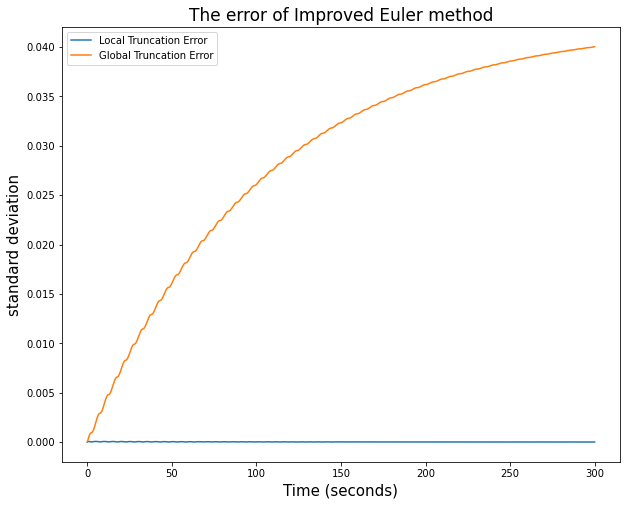

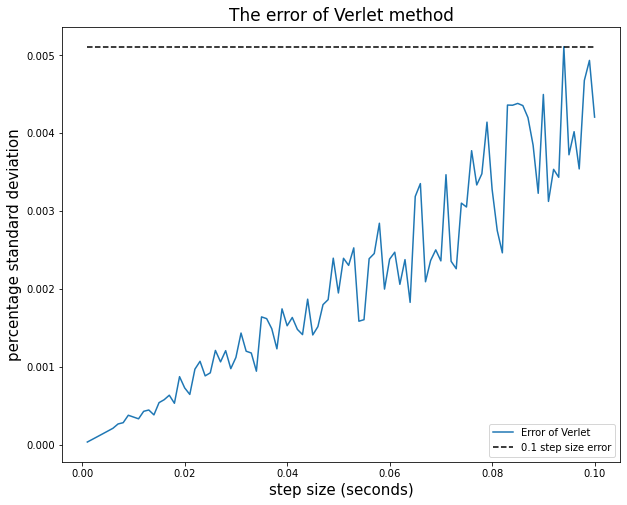

The error of verlet method at 0.1 step size is 0.005110563459590504


In [210]:
VerletError_StepPointOne = np.array([np.amax(verletUncertianty_Array) for i in range(len(verletUncertianty_Array))])
_,_,_, Euler_LocalTruncationError, Euler_GlobalTruncationError = Euler(step_size=0.1)
_,_,_, ImprovedEuler_LocalTruncationError, ImprovedEuler_GlobalTruncationError = Improved_Euler(step_size = 0.1)
#####################################
"Plot Euler method error"
#####################################
METHOD_NAME = np.array(["Local Truncation Error", "Global Truncation Error"])
# array([euler, type:array, improved euler, type: array, verlet, type:array, euler_cromer, type:array])
# [array, array, array, array]
X_ARRAY = [t_array, t_array]
Y_ARRAY = [Euler_LocalTruncationError, Euler_GlobalTruncationError]
plot(
    X_ARRAY,
    Y_ARRAY,
    METHOD_NAME,
    "Time (seconds)",
    "standard deviation",
    "The error of Euler method"
)

#####################################
"Plot Improved Eulermethod error"
#####################################
METHOD_NAME = np.array(["Local Truncation Error", "Global Truncation Error"])
# array([euler, type:array, improved euler, type: array, verlet, type:array, euler_cromer, type:array])
# [array, array, array, array]
X_ARRAY = [t_array, t_array]
Y_ARRAY = [ImprovedEuler_LocalTruncationError, ImprovedEuler_GlobalTruncationError]
plot(
    X_ARRAY,
    Y_ARRAY,
    METHOD_NAME,
    "Time (seconds)",
    "standard deviation",
    "The error of Improved Euler method"
)

######################################################
"find the error of 0.1 step size"
######################################################
METHOD_NAME = ["Error of Verlet", "0.1 step size error"]
# array([euler, type:array, improved euler, type: array, verlet, type:array, euler_cromer, type:array])
# [array, array, array, array]
X_ARRAY = [verletSteps_Array, verletSteps_Array]
Y_ARRAY = [verletUncertianty_Array, VerletError_StepPointOne]
plot(
    X_ARRAY,
    Y_ARRAY,
    METHOD_NAME,
    "step size (seconds)",
    "percentage standard deviation",
    "The error of Verlet method",
    compare=True
)
print(
    "The error of verlet method at 0.1 step size is {}".format(
        VerletError_StepPointOne[0]
    )
)

We can see that although the local truncation error of the Euler method and Improved Euler method seems low, lumping error occurs after accumulating the local truncation error.
The error of energy calculated by Verlet method is approximately $0.51\%$. The expected accuracy for numerical integration is: $$\sigma < 0.1\%, $$ so that the step size of the Verlet method needs to be reduced below 0.02 if the damping constant is 0.2.
We can update the step size below.
However, if the running time is too long, you may skip the next cell. The Verlet method can still provide good accuracy with the current time step size.

In [211]:
STEP_SIZE = 0.02
x_array_empty, v_array_empty, nsteps, t_array = position_velocity_time_array(step_size=STEP_SIZE)

We use the best numerical integration method, the Verlet method, to show three types of oscillation and compare them with analytical method.
The critical value of damping constant can be found with $$b_{critical} = \sqrt{4km}$$
To investigate the heavy damping, we double the b.
$$b_{heavy} = 2\sqrt{4km}$$
To investigate the light damping, we halve the b.
$$b_{light} = \sqrt{km}$$

The critical damping constant is: 6.456004956627589 kg/s


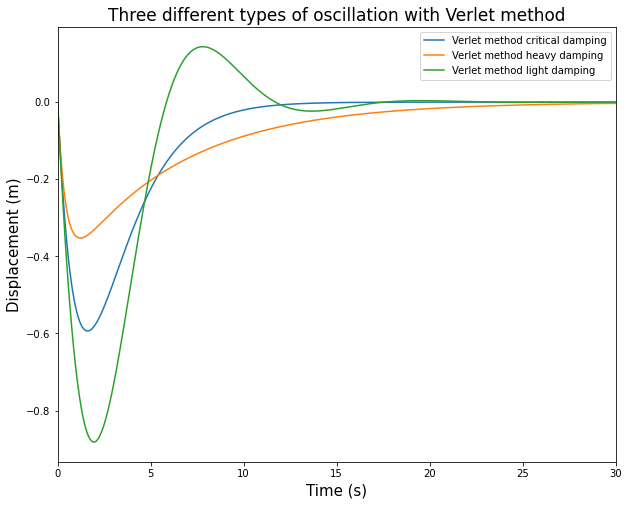

In [212]:
############################
"only use verlet method now"
############################


# set up parameter
b_critical = (4 * K * M) ** 0.5
b_heavy = b_critical * 2
b_light = b_critical / 2
print("The critical damping constant is:", b_critical, 'kg/s')
# get displacement array,and velocity array
displacement_critical_verlet, velocity_critical_verlet, _ = Verlet(
    b=b_critical, step_size=STEP_SIZE
)
displacement_heavy_verlet, velocity_critical_verlet, _ = Verlet(
    b=b_heavy, step_size=STEP_SIZE
)
displacement_light_verlet, velocity_critical_verlet, _ = Verlet(
    b=b_light, step_size=STEP_SIZE
)

#####################################
"Plot"
#####################################
X_ARRAY = [t_array, t_array, t_array]
Y_ARRAY = [
    displacement_critical_verlet,
    displacement_heavy_verlet,
    displacement_light_verlet
]
PLOT_NAME = [
    "Verlet method critical damping",
    "Verlet method heavy damping",
    "Verlet method light damping"
]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "Time (s)",
    "Displacement (m)",
    "Three different types of oscillation with Verlet method",
    xMax=30.0
)

As we expected, the light damping occurs when the damping constants $smaller$ than the critical damping constants. The system motion has an oscillatory behavior with decaying amplitude.

The heavy damping occurs when the damping constants $greater$ than the critical damping value. The oscillation is suppressed, and system motion shows no inflection point after the lowest value.

Critical damping occurs when the damping constants are $equal$ to the critical damping value. The system returns to equilibrium without any oscillation. The motion of critical damping has an inflection point after the lowest value.

<font face="Time New Roman" size=5 color=black >
4. Investigate heterogeneous linear second-order ODE

We solved homogeneous linear second-order ODE in the previous section. We now add a external force to the spring-mass system.                           $$m\ddot{x}(t)+b\dot{x}(t)+kx(t) = F_{external}(t)$$ 
$F_{external}$ can be any form, such as constant or varying like a sinusoidal function. 

To apply a 'push' after a few oscillation periods, we need to carefully modify the Verlet method function. We first let Verlet numerical integration proceed till we apply the force. Then, we need to end the loop and add the push acceleration to our differential equation. Finally, we calculate the rest of the displacement by the Verlet method with no extra modification.

In [213]:
def driven_force(force, start_time, x_0=X_0, v_0=V_0, step_size=STEP_SIZE, m=M, k=K, b=B, t=T):
    """
    The function used for calculate the effect of constant driven force
    applying on spring mass system.
    

    Parameters
    ----------
    force : float or int
        A constant force
    start_time : int
        The start time of applying the push on the spring mass system.
    x_0 : int, optional
        the initial displacement of the mass. The default is X_0.
    v_0 : int, optional
        the initial displacement of the mass. The default is V_0.
    step_size : float, optional
        the step size of the numerical integration. The default is STEP_SIZE.
    m : float, optional
        The mass of the object. Unit in kg  The default is M.
    k : float, optional
        The spring constant of the object. Unit in N/m. The default is K.
    b : float, optional
        The damping constant of the spring. unit in kg/s. The default is B.
    t : int, optional
        Time in s. The default is T.

    Returns
    -------
    x : array
        displacement array of the mass
    v : array
        displacement array of the mass.
    nsteps : int
        the number of subdivision of the time.
    """
    # call improved method to start
    x, v, nsteps, _, _ = Improved_Euler(x_0, v_0, step_size, m, k, b, t)
    # Calculate constants of Verlet Method
    D = 2 * m + b * step_size
    A = 2 * (2 * m - k * step_size ** 2) / D
    B = (b * step_size - 2 * m) / D
    for i in range(1, start_time):
        # Here, the range(start_time) is 1 to "start_time" value - 1.
        # For example, if start time is 10th steps,the last term of i is 9.

        x[i + 1] = (
            A * x[i] + B * x[i - 1]
        )  # Therefore, i+1 is the term where we add a push acceleration.
    a_push = (
        -k / m * x[start_time] - b / m * v[start_time] + force / m
    )  # force/m is the acceleration
    # from constant force according to newton second law

    # We then is able to calculate: x[start_time+1] =  x[start_time] + v[start_time] + 1/2 * a * h^2
    # V[start_time] according to the formula for Verlet method can be written as: (x[start_time + 1] - x[start_time - 1])/2
    # We substitude v[start_time] into x expression, and the following expression is deduced.

    x[start_time + 1] = (
        2 * x[start_time] - x[start_time - 1] + (step_size ** 2 * a_push)
    )  # start_time = i + 1 in the last for loop.
    # start_time is just like x_0.start_time
    # + 1
    # is the term that affect by the push.
    for i in range(start_time + 1, nsteps - 1):
        x[i + 1] = (
            A * x[i] + B * x[i - 1]
        )  # calculate the rest of displacement terms by Verlet method again.
    return x, v, nsteps


We investigate four different situations here. Two of them have the same force, but one push applies in the trough, and one is at the zero displacement point; for the other two situations, the direction of the force is changed, and remain the push at the same part of the oscillation as previous two.

To find the trough and zero point of the spring-mass system, the period of one oscillation is calculated:
    $$T = \frac{2\pi}{\omega}$$ where $\omega$ is equal to $\sqrt{\frac{k}{m}}$

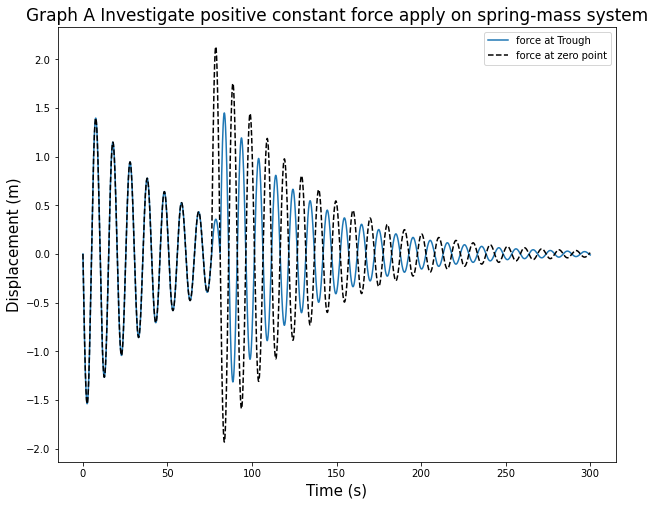

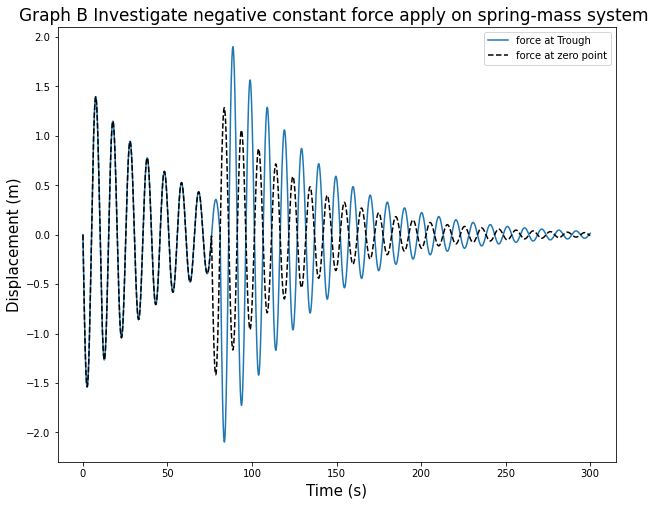

In [214]:
period = 2 * np.pi / (K / M )**0.5
MARK_X = float(8 * period)
# Trough and peak show at the integer times of period depend on the initial location of the mass.
# Here the initial stretch of the spring is positive.
####################
" situation 1"
####################
# F = 300N and start time  is equal to 8th period.The int() function is required because time array is all nature number.
sudden_push_x_1, v1, n1 = driven_force(300, int(8 * period/STEP_SIZE))
sudden_push_x_2, v2, n2 = driven_force(300, int((8 * period/STEP_SIZE)-(period/STEP_SIZE)/2))
X_ARRAY = [t_array, t_array]
Y_ARRAY = [sudden_push_x_1, sudden_push_x_2]
PLOT_NAME = ['force at Trough', 'force at zero point']
plot(X_ARRAY, Y_ARRAY, PLOT_NAME, 'Time (s)', 'Displacement (m)', 
     'Graph A Investigate positive constant force apply on spring-mass system', 
     compare = True
    )
###################
"situation 2"
####################
# F = -300N and start time is equal to 8th period.
sudden_push_x_1, v1, n1 = driven_force(-300, int(8 * period/STEP_SIZE))
sudden_push_x_2, v2, n2 = driven_force(-300, int((8 * period/STEP_SIZE)-(period/STEP_SIZE)/2))
X_ARRAY = [t_array, t_array]
Y_ARRAY = [sudden_push_x_1, sudden_push_x_2]
PLOT_NAME = ['force at Trough', 'force at zero point']
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "Time (s)",
    "Displacement (m)",
    "Graph B Investigate negative constant force apply on spring-mass system ",
    compare=True
)


To show how the force affects the oscillation of mass, we let the system underdamped.

The mass acceleration direction at the trough of the displacement curve is positive because the curve shape at this point is concave up; the inflection point indicates the acceleration at zero point is zero.

The graphs show the amplitude of oscillation decreases after each completed period. When the push applies to the system, the acceleration of the mass is suddenly changed. The new amplitude of the mass increases if the direction of the instantaneous velocity of mass and the push direction are in the same orientation.

For example, in graph A, the force is positive so that the push does not further stretch the spring, but speeds up the mass to go back to the positive direction, while the force is negative in graph B so that the mass is pushed towards a higher displacement. In contrast, when the constant force applies to the mass at the zero point, the displacement amplitude of mass in graph A is greater than the one in graph B due to the push being in the same direction as the instantaneous velocity in graph A.

The step size vitally interrelates the amplitude. As the step size decreases, a greater force is required to change the state motion of the mass. 

Therefore, we finally conclude that if the push increases or reduces the momentum of the mass, the amplitude of the mass will correspondingly to increases or decrease.

We now look at the case when the periodically driven force is sinusoidal.

In [215]:
def periodic_driven_force(
    force,
    time,
    start_time,
    frequency,
    x_0=X_0,
    v_0=V_0,
    step_size=STEP_SIZE,
    m=M,
    k=K,
    b=B,
    t=T
):
    """
    
    periodic driven force
    
    Parameters
    ----------
    force : int
        The anplitude of the periodic driven force
        
    time : array
    the time array
    
    start_time : int
        The start time of applying the push on the spring mass system.
    x_0 : int, optional
        the initial displacement of the mass. The default is X_0.
    v_0 : int, optional
        the initial displacement of the mass. The default is V_0.
    step_size : float, optional
        the step size of the numerical integration. The default is STEP_SIZE.
    m : float, optional
        The mass of the object. Unit in kg  The default is M.
    k : float, optional
        The spring constant of the object. Unit in N/m. The default is K.
    b : float, optional
        The damping constant of the spring. unit in kg/s. The default is B.
    t : int, optional
        Time in s. The default is T.

    Returns
    -------
    x : array
        displacement array of the mass
    v : array
        displacement array of the mass.
    nsteps : int
        the number of subdivision of the time.
    """
    #Rescaling the time array so that the start_time(th) term is equal to zero.
    time = time - start_time * STEP_SIZE
    periodic_force = force * np.cos(frequency * time)
    D = 2*m + b*step_size
    A = 2*(2*m - k * step_size**2)/D
    B = (b*step_size - 2*m)/D
    
    #call improved method to start
    
    x, v, nsteps, _, _ = Improved_Euler(x_0, v_0, step_size, m, k, b, t)
    a = np.zeros(nsteps)
    for i in range(1, start_time):
        x[i+1] = A*x[i] + B*x[i-1]# The last i+1 term gives [start time] e.x.[[],[start_time - 1],[start_time] ,[...]]
    
    #prevent the index error
    if nsteps - 1 == start_time:
        print('Start time reaches the maximum steps')
        sys.exit()
        
    #start the verlet method by other methods
    # Add acceleration to the start-time (th) term
    a[start_time] = -(k/m)*x[start_time] - (b/m)*v[start_time] + (periodic_force[start_time]/m)
    
    #calculate displacement and velocity as previous
    x[start_time + 1] = x[start_time] + v[start_time]*step_size + a[start_time] * (step_size**2 / 2)
    v[start_time + 1] = v[start_time] + a[start_time]*step_size
    
    for i in range(start_time + 1, nsteps - 1):
        x[i+1] = A*x[i] + B*x[i-1]# [start_time](x[i]) in this iteration correspond to [i+1] in the last iteration.
                                   # Therefore, i-1 is start time - 1
                                    #First calculation: [[start_time - 1],[start_time],[x[i+1]]]
        v[i] = (x[i+1] - x[i-1]) / (2 * step_size)
        a[i] = -(k/m)*x[i] - (b/m)*v[i] + periodic_force[i]/m # update the acceleration
        x[i+1] = (2 * x[i] + (step_size**2) * a[i]) - x[i-1] #update the displacement
    peaks, _ = find_peaks(x, height=0)

    for l in range(len(peaks)-1):

        if np.abs(x[peaks[l+1]] - x[peaks[l]]) < 0.0001:
    #The difference between neighbouring peaks is small, the system at l is in the steady state
             break

    amplitude = x[peaks[l]] #Obtaining the steady state amplitude

    return x, v, nsteps, amplitude

Here we assume the amplitude of periodic driven force is 1N. The frequency is selected to be 0.75 times the natural frequency of the system. We also try to let the frequency of the driven force be the same as the natural frequency to investigate the resonance.

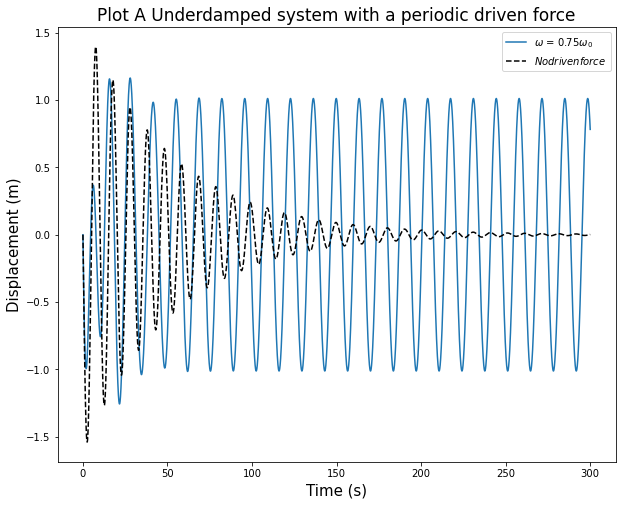

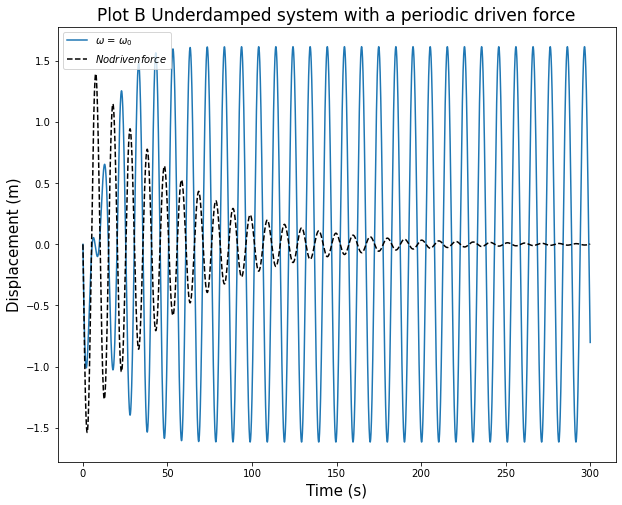

In [216]:
###################
"parameter"
###################
time_array = np.linspace(0, T, nsteps)
FORCE = 1  # The amplitude of the periodic force
START_TIME = 0  # Choose a start time of applying periodic force on the system
NATURE_FREQUENCY = (K / M) ** 0.5  # nature frequency
# the frequency of the periodic force. We give periodic driven force threee different frequencies
FREQUENCY = 0.75 * NATURE_FREQUENCY
# The integer multiplies of the nature frequency. We expect to see a resonance.
FREQUENCY_RESONANCE = NATURE_FREQUENCY

# for quicker decay, set a bigger damping constant.
B = 1

######################################################
"call function to calculate displacement of the mass"
######################################################
# calculate the displacement of the mass after applying the periodic force
driven_force, _, _, _ = periodic_driven_force(
    FORCE, time_array, START_TIME, FREQUENCY, b=B
)
driven_force_resonance, _, _, _ = periodic_driven_force(
    FORCE, time_array, START_TIME, FREQUENCY_RESONANCE, b=B
)
# calculate the displacement of the mass without any driven force
reference_displacement, _, _ = Verlet(step_size=STEP_SIZE)

#######################
"plot procedure"
#######################
# set up plot for the periodic driven frequency equals to 0.75 nature frequency.
X_ARRAY = [t_array, t_array]
Y_ARRAY = [driven_force, reference_displacement]
PLOT_NAME = ["$\omega$ = $0.75\omega_{0}$", "$No driven force$"]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "Time (s)",
    "Displacement (m)",
    "Plot A Underdamped system with a periodic driven force",
    compare=True
)

# set up plot for the periodic driven frequency equals to nature frequency.
X_ARRAY = [time_array, time_array]
Y_ARRAY = [driven_force_resonance, reference_displacement]
PLOT_NAME = ["$\omega$ = $\omega_{0}$", "$No driven force$"]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "Time (s)",
    "Displacement (m)",
    "Plot B Underdamped system with a periodic driven force",
    compare=True
)


At the beginning of the periodically driven force applying to the system, both plots show an irregular oscillation which means they are in the transient period. The oscillation becomes steady when the spring-mass system itself energy depletes. Plot A shows a steady oscillation after the spring-mass system stops motion under the light damping when the periodically driven force has a frequency different from the natural frequency. Plot B shows that the displacement of mass is higher and higher, which indicates the system is resonant as we expected.

<font face="Time New Roman" size=5 color=black >
5.Damping constants and resonance

In plot B, we show the resonance with the known nature frequency of the system. How to find out the resonance of a system if we do not know its natural frequency?
In the experiment, we usually tune the wave generator and observe which frequency could give us the highest amplitude on the oscilloscope screen. In the same analogy, we tried a range of the frequency by creating a frequency array and using the Scipy build-in function to get the maximum amplitude.
We use verlet method to investigate the resonance of the system in the range $$\frac{1}{2}\omega_{0} <= \omega <= \frac{3}{2}\omega_{0}$$
$\omega_{0}$ is the nature frequency.
We noticed in the last section that the damp constant also affect the amplitude of the mass displacement. Hence, we will try three different damping constant, $B$, $0.9B$, and $0.8B$.

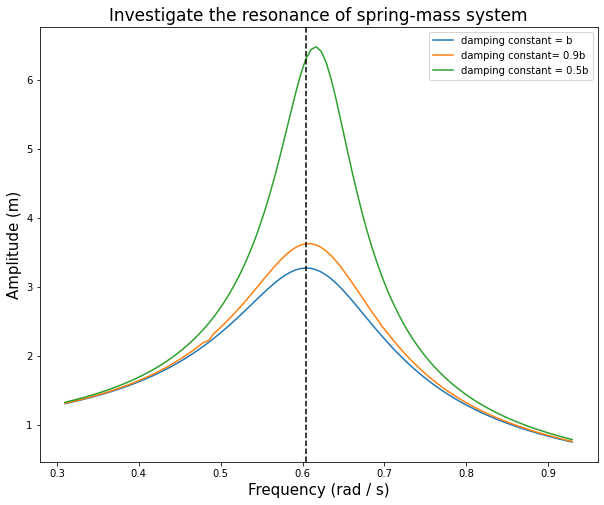

In [217]:
#find the low boundary
low_frequency_boundary = 0.5 * NATURE_FREQUENCY
#find the high boundary
high_frequency_boundary = 1.5 * NATURE_FREQUENCY
#create the frequency array list
frequency_array = np.linspace(low_frequency_boundary, high_frequency_boundary, 100)
#create a array list to fill in amplitude of spring mass system under the effect of different driven force frequency.
amplitude_array_1 = np.zeros(len(frequency_array))
amplitude_array_2 = np.zeros(len(frequency_array))
amplitude_array_3 = np.zeros(len(frequency_array))

#calculate the amplitude of oscillation and append them in the array list
for i in range(len(frequency_array)):
    _,_,_,amplitude_array_1[i] = periodic_driven_force(-2, time_array, 0,  frequency_array[i], b = B)
    _,_,_,amplitude_array_2[i] = periodic_driven_force(-2, time_array, 0,  frequency_array[i], b = 0.9*B)
    _,_,_,amplitude_array_3[i] = periodic_driven_force(-2, time_array, 0,  frequency_array[i], b = 0.5*B)
#calculate the frequency at the resonance
max_amplitude_index_1 = np.where(amplitude_array_1 == np.amax(amplitude_array_1))
max_amplitude_index_2 = np.where(amplitude_array_2 == np.amax(amplitude_array_2))
max_amplitude_index_3 = np.where(amplitude_array_3 == np.amax(amplitude_array_3))
max_position_1 = frequency_array[max_amplitude_index_1]
max_position_2 = frequency_array[max_amplitude_index_2]
max_position_3 = frequency_array[max_amplitude_index_3]

##########
"Plot"
##########
X_ARRAY = [frequency_array, frequency_array, frequency_array]
Y_ARRAY = [amplitude_array_1, amplitude_array_2, amplitude_array_3]
PLOT_NAME = ['damping constant = b','damping constant= 0.9b', 'damping constant = 0.5b']
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "Frequency (rad / s)",
    "Amplitude (m)",
    "Investigate the resonance of spring-mass system",
    mark_x=max_position_1[0]
)

In [218]:
print('The frequency at resonance with damping constant = b {0: .3f}'.format(max_position_1[0]))
print('The frequency at resonance with damping constant = 0.9b {0: .3f}'.format(max_position_2[0]))
print('The frequency at resonance with damping constant = 0.5b {0: .3f}'.format(max_position_3[0]))

averaged_position = (max_position_1+max_position_2+max_position_3)/3
print('The averaged frequency at resonance is:{0: .3f}'.format(averaged_position[0]))

The frequency at resonance with damping constant = b  0.604
The frequency at resonance with damping constant = 0.9b  0.610
The frequency at resonance with damping constant = 0.5b  0.616
The averaged frequency at resonance is: 0.610


In [219]:
print("The nature frequency of the system is: {0:.3f}".format(NATURE_FREQUENCY))

The nature frequency of the system is: 0.620


The frequency at resonance for three different damping constants should be the same. However, since the numerical integration has an inevitable error, the small deviation of frequency at resonance for different damping constant is acceptable. The averaged frequency at resonance is 0.610 rad/s. Compare with the nature frequency of the system, 0.620 rad/s, the averaged frequency at resonance has 2% error.

The amplitude of a spring-mass system with a periodically driven force seems to depend on the damping constant because the curve with lower damping constant can always enclose the one with a higher damping constant, but the maximum amplitude is always at the point where the driven frequency equals to the natural frequency and the resonance happens.

To further investigate the effect of the damping constant on the resonance amplitude, we can draw an amplitude against damping constant plot to investigate the relationship between them. To save the running time, we set the driven frequency equal to the natural frequency instead of traversing a range of frequencies to find out the peak of amplitude. The X value, the damping constant of the system, is in the range $$ 0<=X<= \frac{3}{2}B$$
B is the default damping constant.

In [220]:
print('The value of damping constant(B) is:', B, 'kg/s')

The value of damping constant(B) is: 1 kg/s


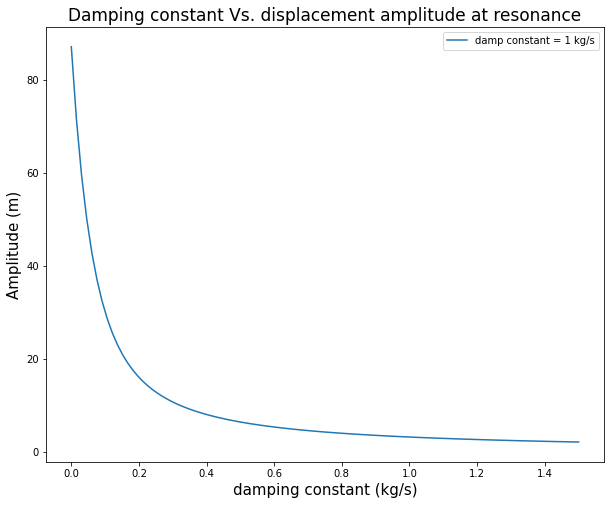

In [221]:
# create an array for damping constants
b_array = np.linspace(0, 1.5 * B, 100)
# constants
FORCE = 2
START_TIME = 0
amplitude_array_b = np.zeros(len(b_array))
# get the amplitude of the oscillation of mass with different damping constants
for i in range(len(b_array)):
    _, _, _, amplitude_array_b[i] = periodic_driven_force(
        FORCE, time_array, START_TIME, frequency=NATURE_FREQUENCY, b=b_array[i]
    )
############
"plot"
############
X_ARRAY = [b_array]
Y_ARRAY = [amplitude_array_b]
PLOT_NAME = ["damp constant = 1 kg/s"]
plot(
    b_array,
    amplitude_array_b,
    PLOT_NAME,
    "damping constant (kg/s)",
    "Amplitude (m)",
    "Damping constant Vs. displacement amplitude at resonance",
    multimethod=False
)


The function looks like an exponential decay function or a reciprocal function. Let's define the general form of these two functions.

In [222]:
def exponential_function(x, a, b, c):
    """
    return a exponential function that has the general form
    A * e^(bx + C)

    Parameters
    ----------
    x : array
        x data
    a : float
        parameter.
    b : float
        parameter.
    c : float
        parameter.

    Returns
    -------
    array
        the y value of exponential function calculated by the input x value

    """
    return a * np.exp(x * b + c)


def reciprocal_function(x, a, b, c):
    """
    return a reciprocal function that has the general form
      A
    ______ + C
    
    (x+b)   

    Parameters
    ----------
    x : array
        x data
    a : float
        parameter.
    b : float
        parameter.
    c : float
        parameter.

    Returns
    -------
    array
        the y value of reciprocal function calculated by the input x value

    """
    return a / (x + b) + c


To see which function better describes the relationship between damping constant and maximum amplitude of the function, we can do a curve fitting which concomitantly gives us the parameter of the function. It is worth noticing that the global error of the Verlet is hard to calculate. Therefore, we can create a reasonable noise to simulate the real-world experiment. We assume the noise follow the gaussian distribution as the convention.

Since we are guessing the model, the covariance of the wrong candidate model parameters might be very largely dependent on the random noise, which could result in the optimize warning. You can try to run the next cell several times till there is no optimize warning.

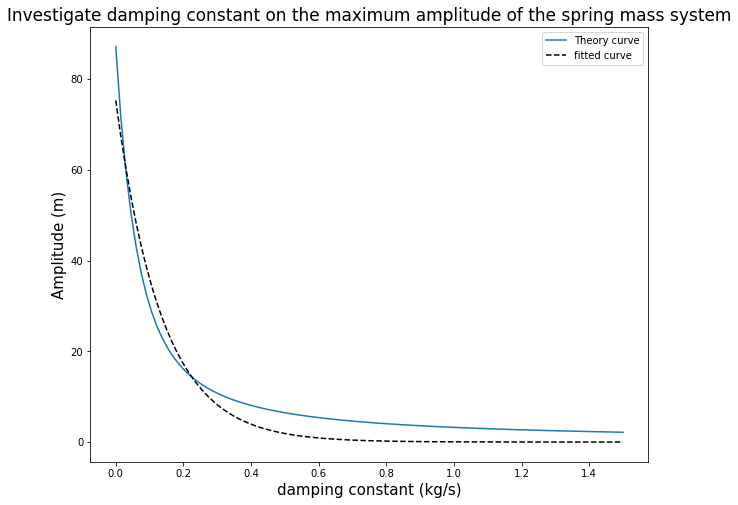

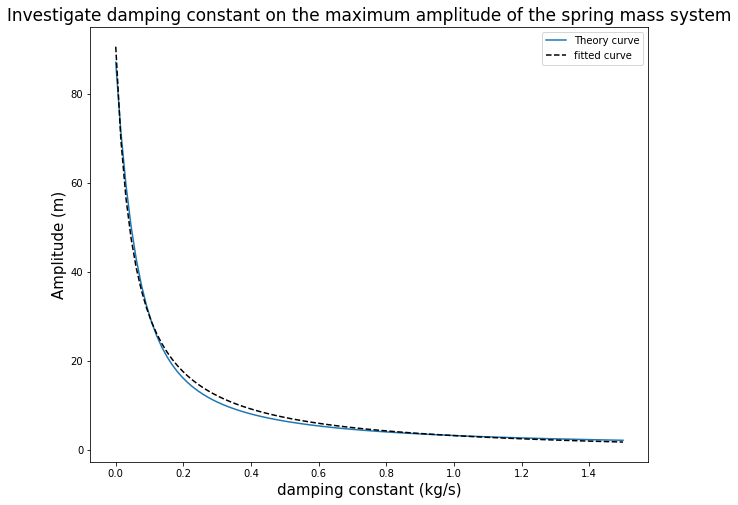

In [227]:
#############################
"simulate experiment data"
#############################
x_data = b_array  # x data for curve fitting
y_data = amplitude_array_b  # x data for fitting the curve
randomNumerGenerator = np.random.default_rng()  # call random number generator
y_noise = randomNumerGenerator.normal(
    size=x_data.size
)  # generate y error that follows gaussian distribution
y_data = y_data + y_noise  # add noise in our "perfect" y data

################################
"fitting procedure"
################################
# fit exponential function
parameter_list_1, parameter_uncertainty_1 = curve_fit(
    exponential_function, x_data, y_data
)
y_fitted_1 = exponential_function(
    x_data, parameter_list_1[0], parameter_list_1[1], parameter_list_1[2]
)  # the y value generated by the function with a fitted paramter.

# fit reciprocal function
parameter_list_2, parameter_uncertainty_2 = curve_fit(
    reciprocal_function, x_data, y_data
)
y_fitted_2 = reciprocal_function(
    x_data, parameter_list_2[0], parameter_list_2[1], parameter_list_2[2]
)

######################
"plot"
######################
# plot exponential function
X_ARRAY = [x_data, x_data]
Y_ARRAY = [amplitude_array_b, y_fitted_1]
PLOT_NAME = ["Theory curve", "fitted curve"]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "damping constant (kg/s)",
    "Amplitude (m)",
    "Investigate damping constant on the maximum amplitude of the spring mass system",
    compare=True
)

# plot reciprocal function
X_ARRAY = [x_data, x_data]
Y_ARRAY = [amplitude_array_b, y_fitted_2]
PLOT_NAME = ["Theory curve", "fitted curve"]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "damping constant (kg/s)",
    "Amplitude (m)",
    "Investigate damping constant on the maximum amplitude of the spring mass system",
    compare=True
)

The reciprocal function is better than exponential function to describe relationship between amplitude at resonance and damping constant according to the simulation above. We can use the chi square test to test the model's reliability.

In [228]:
def reshaper(x_value, y_value, y_uncertainty):
    """
    reshape the data array

    Parameters
    ----------
    x_value : array
        x axis value
    y_value : array
        y axis value
    y_uncertainty : array
        y uncertainty

    Returns
    -------
    data_array : a [n * 3] array
        x, y, y uncertainty data in an array

    """
    x_reshape = x_value.reshape(len(x_value), 1)
    y_reshape = y_value.reshape(len(y_value), 1)
    y_noise_reshape = y_uncertainty.reshape(len(y_uncertainty), 1)
    data_array = np.hstack((x_reshape, y_reshape, np.abs(y_noise_reshape)))
    data_array = np.hstack((data_array, y_reshape))
    data_array = np.hstack((data_array, y_noise_reshape))
    return data_array


def chi_squared_function(parameters, data_array, function):
    """
    the chi2 function

    Parameters
    ----------
    parameters : tuple
        the parameter of the distribution function
    data_array : array
        data contain x value, y value, and y uncertainty
    function : an distribution function

    Returns
    -------
    chi_square : float
        chi squared value
    reduced_chi_square :
        reduced chi squared value

    """
    a, b, c = parameters
    chi_square = np.sum(
        ((function(data_array[:, 0], a, b, c) - data_array[:, 1]) / data_array[:, 2])
        ** 2
    )
    reduced_chi_square = chi_square / (len(data_array) - len(parameters))
    return chi_square, reduced_chi_square


In [229]:
data_array = reshaper(x_data, amplitude_array_b, y_noise)

chiSquaredReciprocal = chi_squared_function(
    parameter_list_2, data_array, reciprocal_function
)
chiSquaredExponential = chi_squared_function(
    parameter_list_1, data_array, exponential_function
)
print(
    "The reduced chi squared value of reciprocal model is:",
    chiSquaredReciprocal[1]
)
print(
    "The reduced chi squared value of exponential model is:",
    chiSquaredExponential[1]
)
a, b, c = parameter_list_2

The reduced chi squared value of reciprocal model is: 23.78950410506394
The reduced chi squared value of exponential model is: 769.0116532835193


The value of reduced chi sqaured for reciprocal function is typically less than 100(The noise follows the gaussian distribution) and its fluctuation is highly depend on our noise generated by random number generator. The reduced chi squared value of exponential function is typically 10 - 30 times larger than the one of reciprocal function.

From the simulated experiment above. We can conclude that:(run the next cell!)

In [230]:
print('The relationship between damping constant(B) and amplitude at resonance(A) is:A = {0:.3f}/(B + {1:.3f})  {2:.3f}.'
      .format(a, b, c))

The relationship between damping constant(B) and amplitude at resonance(A) is:A = 4.727/(B + 0.051)  -1.279.


<font face="Time New Roman" size=5 color=black >
6. Use numerical integration to solve Schrodinger equation. <148>

In this section, we finally can write some code to solve a more complicated differential equation, Schrodinger equation. 

The one dimension time independent Schrodinger equation is $$\frac{-\hbar^2}{2m}\frac{\partial\psi^2(x)}{\partial x^2}+V(x)\psi(x) = E\psi$$
$\psi$ is the wavefunction who depends on the space. We only study the dimension situation in this project. $E$ is the eigenvalue. V(x) is the potential of the space. We will discuss the situation when V(x) is zero, infinite potential wall and a simple harmonic oscillator.
Let's define the analytical solution of the Schrodinger equation.

In quantum mechanics, we do not want to study a space that has no potential because that will result in a high uncertainty on the position of the particle and vanish the particle's energy. We need to set a constraint on the no potential space. If the space has no potential in the one dimension from 0 to a and infinite potential anywhere else, then the Schrodinger equation can be simplified as:
$$\frac{-\hbar^2}{2m}\frac{\partial\psi^2(x)}{\partial x^2} =  E\psi$$
The analytical solution is then has the form of $$\psi (x) = Asin(kx) + Bcos(kx)$$ where $k = \sqrt{\frac{2mE}{\hbar^2}}$ and $E = \frac{1}{2m}(n\frac{\pi \hbar}{a})^2$. n is a nature number that represent the energy level.
Due to the fact that there are no pobability at the edge of the potential wall and the wavefunction must normalized because it is a probability function, the solution of one dimension schrodinger equation is writen as $$\psi(x) = \sqrt{\frac{2}{a}}sin(kx)$$
The analytical solution of quantum harmonic oscillator is $$\psi(x) = \frac{m\omega}{\pi\hbar}^{\frac{1}{4}}\frac{1}{\sqrt{2^n n!}} H_{n}\frac{m\omega}{\hbar}^\frac{1}{2} e^{-\frac{m\omega}{2\hbar}x^2}$$

Though the size of the unit plays an important role in the wavefunction, what we need to compute is the linear partial derivative and the eigenvalue of the energy. To avoid the frequency overflow problem and running time problem, we can set these constants as 1 and convert them later.

We study the oscillation at the microscopic level. The constant is carbon monoxide.

In [231]:
x_0 = 0 #initial position of the atom unit: m
m_0 = 12*16/(12+16)*1.66*10**-27 #the central mass of the atom unit: kg
a_0 = 10**-10 # 1 amstrong unit:m
k_0 = 1680 # the spring constants unit:kg/m
w_0 = 6.43*10**13 # oscillation frequency unit: rad/s
n_0 = 10000 # number of steps unitless

Let's now code the analytical solution of Schrodinger equation.

In [232]:
def schrodinger_free_space(x, m=m_0, a=a_0, n=n_0):
    """
    The analytical solution of free space wavefunction.

    Parameters
    ----------
    x : array or int
        position
    m : float, optional
        mass. The default is m_0.
    a : float, optional
        the displacement range. The default is a_0.
    n : int, optional
        the energy state. The default is n_0.

    """
    E = 1 / (2 * m) * ((n * np.pi * constants.hbar) / a) ** 2
    K = ((2 * m * E) / (constants.hbar ** 2)) ** 0.5
    # normalisation constant
    A = (2 / a) ** 0.5
    return A * np.sin(K * x)


def hermite(x, n, m=m_0, w=w_0):
    """
    Hermite polynomial

    Parameters
    ----------
    x : array or int
        position
    m : float, optional
        mass. The default is m_0.
    w : float, optional
        the frequency of diatomic molecule
    n : int, optional
        the energy state.

    """
    xi = np.sqrt(m * w / constants.hbar) * x
    herm_coeffs = np.zeros(n + 1)
    herm_coeffs[n] = 1
    return Hermite.hermval(xi, herm_coeffs)


def schr_sim_har_osc(x, n, m=m_0, w=w_0):
    """
    The analytical solution of QM SHO space wavefunction.

    Parameters
    ----------
    x : array or int
        position
    m : float, optional
        mass. The default is m_0.
    w : float, optional
        the frequency of diatomic molecule
    n : int, optional
        the energy state.

    """
    xi = np.sqrt(m * w / constants.hbar) * x
    prefactor = (
        1.0
        / math.sqrt(2.0 ** n * math.factorial(n))
        * (m * w / (np.pi * constants.hbar)) ** (0.25)
    )
    psi = (
        prefactor
        * np.exp(-(xi ** 2) / 2)
        * hermite(x, n, m, w)
    )
    return psi


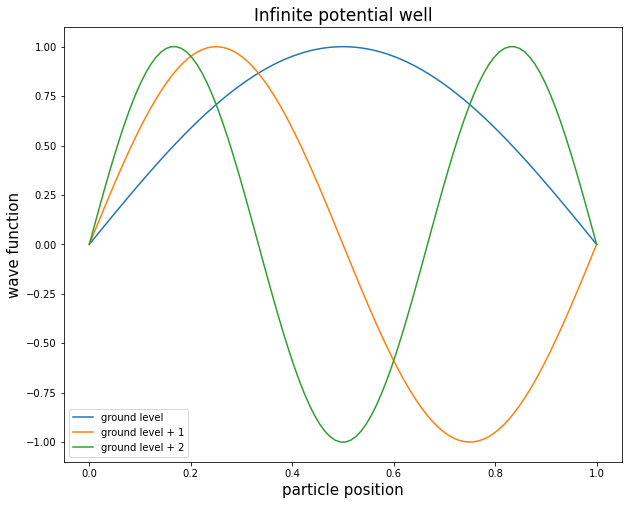

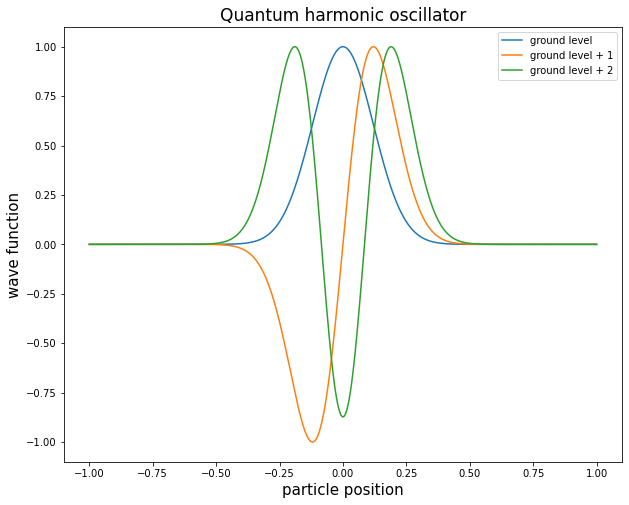

In [233]:
#########################
"step into main program"
#########################
"Plot free space wavefunction"
#########################
# create position array
x_array = np.linspace(0, a_0, 100)
# find wavefunction
free_space_wavefunction_ground = schrodinger_free_space(x_array, n=1)
free_space_wavefunction_one = schrodinger_free_space(x_array, n=2)
free_space_wavefunction_two = schrodinger_free_space(x_array, n=3)

#standardize
X_ARRAY = [x_array/np.amax(x_array), x_array/np.amax(x_array), x_array/np.amax(x_array)]
Y_ARRAY = [
    free_space_wavefunction_ground/np.amax(free_space_wavefunction_ground),
    free_space_wavefunction_one/np.amax(free_space_wavefunction_one),
    free_space_wavefunction_two/np.amax(free_space_wavefunction_two)
]
PLOT_NAME = ["ground level", "ground level + 1", "ground level + 2"]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "particle position",
    "wave function",
    "Infinite potential well"
)
#########################
"Plot QM SHO wavefunction"
#########################
x_array = np.linspace(-a_0, a_0, 6000)
QM_SHO_ground = schr_sim_har_osc(x_array, 0)
QM_SHO_first = schr_sim_har_osc(x_array, 1)
QM_SHO_second = schr_sim_har_osc(x_array, 2)
#standardize
X_ARRAY = [x_array/np.amax(x_array), x_array/np.amax(x_array), x_array/np.amax(x_array)]
Y_ARRAY = [QM_SHO_ground/np.amax(QM_SHO_ground), QM_SHO_first/np.amax(QM_SHO_first), QM_SHO_second/np.amax(QM_SHO_second)]
PLOT_NAME = ["ground level", "ground level + 1", "ground level + 2"]
plot(
    X_ARRAY,
    Y_ARRAY,
    PLOT_NAME,
    "particle position",
    "wave function",
    "Quantum harmonic oscillator"
)

Now, we define the potential function of quantum harmonic oscillator

In [234]:
def potential(position):
    """

    Parameters
    ----------
    x : array or float or int
    
        position of the wave
        

    Returns
    -------
        The potential energy array corresponding to position

    """
    return 1 / 2 * position**2


We have already seen the analytical solution of Schrodinger equation. Similar to the numerical solution of simple harmonic motion, we have the numerical algorithm to solve the Schrodinger equation. <br>
Schrodinger equation is a second order linear partial differential equation. The general form can be writen as:$$\frac{d^2y}{dx^2} = -g(x)y(x) + s(x)$$ For Schordinger equation, $g(x) = \frac{2m}{\hbar^2}(E-V(x))$ where V(x) is potential function and E the eigenstates energy. 
<br>
Firstly, we need to taylor expand the $y(x)$ up to fifth order:
    $$y_{i-1} = y_{i} - y'_{i}h + \frac{1}{2}y''_{i}h^2 - \frac{1}{6}y'''_{i}h^3+\frac{1}{24}y''''_{i}h^4 - \frac{1}{120}y'''''_{i}h^5$$
        $$y_{i+1} = y_{i} + y'_{i}h + \frac{1}{2}y''_{i}h^2 + \frac{1}{6}y'''_{i}h^3+\frac{1}{24}y''''_{i}h^4 + \frac{1}{120}y'''''_{i}h^5$$
Then, we can add this two equation up:
    $$y_{i-1} + y_{i+1} = 2y_{i} + y''_{i}h^2 + \frac{1}{12}y''''_{i}h^4 + O(h^6)$$
The accuracy requirement in the quantum mechanics is rigorous, so we reduce the error to six order.
We set the $y''_{i} = z_{n}$ to simplify the rest derivation. Taking the second derivative of y with respect to x, we get
 $$z_{i-1} + z_{i+1} = 2z_{i} + z''_{i}h^2 + O(h^4)$$
 $$y''''_{i} = z''_{i} = \frac{z_{i+1}+z_{i-1}-2z_{i}}{h^2}+O(h^2)$$
 
We can substitude this equation back to $$y_{i-1} + y_{i+1}$$
After some algebra, a iteration equation is shown below. This is the Numerov's formula that was derived by the Russian astronomer Numorov. This equation can solve the second order differential equation in which the first-order term disappear.
$$y_{i+1}[1 + g_{i+1}\frac{h^2}{12}] = 2y_{i}[1 - 5g_{i}\frac{h^2}{12}]-y_{i-1}[1 + g_{i-1}\frac{h^2}{12}]+[s_{i+1}+10s_{i}+s_{i-1}]\frac{h^2}{12} + O[h^6]$$
In the Schrodinger equation, s term does not exist. To further simplify this equation, we could assign an auxiliary array $f_{n} = 1 + g_{n}\frac{h^2}{12}$ where $g_{n} = \frac{2m}{\hbar^2}[E - V(x_{n})]$ . Finally, the Numerov's method is $$y_{n+1} = \frac{(12-10f_{n})y_{n}-f_{n-1}y_{n-1}}{f_{n+1}}$$
$y$ in quantum mechenics is the wave function. 

Noting that we need two values of wave function to initialize the Numerov's method.Since we start from the left boundary of the wave function, the quantum mechanics tells us that the wavefunction must be zero. The second index of the wave function array is hence set as a very small value.
Although it is easy to code the Numerov's method, but it is hard to calculate a correct wave function because the energy eigenvalue is unknown.
Now, let's first look at the situation that we have already known the energy eigenvalues. we can use Numerov's method to calculate the wave function in the infinite potential well.

In [235]:
def numerical_solution(x, m=m_0, a=a_0, n=n_0):
    """


    Parameters
    ----------
    x : array
        wave function position
    m : float, optional
        mass of the object. The default is m_0.
    a : float, optional
        the position interval. The default is a_0.
    n : int, optional
        number of steps. The default is n_0.

    Returns
    -------
    wave_functionArray : the wave function value array
    fn : array
        auxiliary function array.

    """
    # create a array with each value is equal to the step size of the position array
    steps_array = x[1] - x[0] + np.zeros(x.size)
    # The auxiliary array
    fn = np.zeros(x.size)
    wave_functionArray = np.zeros(x.size)
    potential_Array = np.zeros(x.size)

    position_step_size = x[1] - x[0]
    # terms of Numerov's method
    E = 1 / (2 * m) * ((n * np.pi * constants.hbar) / a) ** 2
    gn = (2 * m / constants.hbar ** 2) * (E - potential_Array)
    fn = 1 + (gn * position_step_size ** 2) / 12

    # setting up the hillclimbing methods to find out the accurate starting value of wave function
    # that normalize the wave function
    max_repetition = 100
    tolerance = 0.0005
    mark_point = 1
    difference = 1
    amplify = 0.5
    count = 0
    # guess the start value of wavefunction
    max_starter = 0.001
    wave_functionArray[1] = max_starter
    ###########################################
    #start here
    while abs(difference) > tolerance:

        # iteration 0

        count += 1
        wave_functionArray_maximum = wave_functionArray
        wave_functionArray_maximum[1] = max_starter

        # define the wave function that has bigger or smaller start value
        wave_functionArray_maximum_left = np.zeros(wave_functionArray.size)
        wave_functionArray_maximum_left[1] = (1 + amplify) * max_starter
        wave_functionArray_maximum_right = np.zeros(wave_functionArray.size)
        wave_functionArray_maximum_right[1] = (1 - amplify) * max_starter
        # Numerov's method
        for i in range(1, x.size - 1):
            wave_functionArray_maximum_left[i + 1] = (
                (12 - 10 * fn[i]) * wave_functionArray_maximum_left[i]
                - wave_functionArray_maximum_left[i - 1] * fn[i - 1]
            ) / fn[i + 1]
            wave_functionArray_maximum[i + 1] = (
                (12 - 10 * fn[i]) * wave_functionArray[i]
                - wave_functionArray[i - 1] * fn[i - 1]
            ) / fn[i + 1]
            wave_functionArray_maximum_right[i + 1] = (
                (12 - 10 * fn[i]) * wave_functionArray_maximum_right[i]
                - wave_functionArray_maximum_right[i - 1] * fn[i - 1]
            ) / fn[i + 1]
        # calculate the total probability by summing up the wave function conjugate.
        # To make the function concave, we need to give it a - sign. We expect "maxi" function converging to 0

        maxi = 1 - np.sum(wave_functionArray_maximum ** 2 * steps_array)
        #print(maxi)   
        
        # if you want to see the convergence, you can add above comment in the code
        # if maxi greater than zero, we let the start value equal to maximum left
        if maxi > 0:
            max_starter = wave_functionArray_maximum_left[1]
            difference = maxi
            # stop greedy method, shrink the step size to find a more accurate starting value of wave function
            if abs(maxi) < 0.1 * abs(mark_point):
                amplify = amplify * 0.1
                mark_point = maxi
        # if maxi less than zero, we let the start value equal to maximum right
        elif maxi < 0:
            max_starter = wave_functionArray_maximum_right[1]
            difference = maxi
            if abs(maxi) < 0.1 * abs(mark_point):
                amplify = amplify * 0.1
                mark_point = maxi
        # if something else happens, we say fail and break the loop
        else:
            print("fail")
            break
        # if the the maximum repetition met, we break the look
        if count == max_repetition:
            print("max repetition")
            break
    return wave_functionArray, fn

To test the accuracy of the Numerov's method, let's compare it with the analytical solution

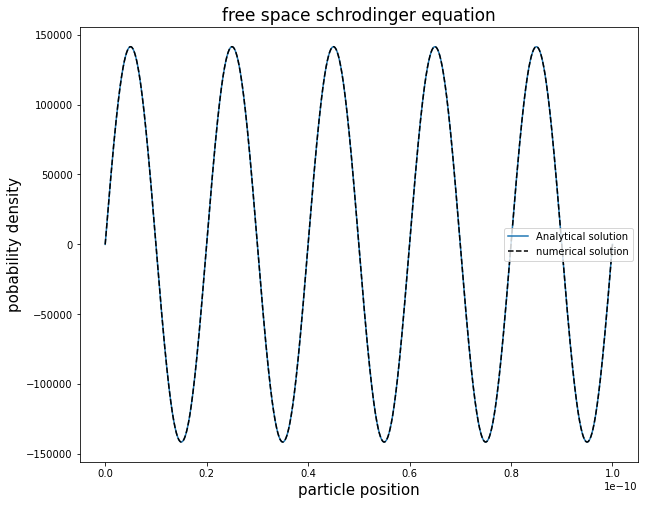

In [236]:
x_array = np.linspace(0, a_0, 10000)

free_spaec_analytical_solution = schrodinger_free_space(x_array, n = 10)
free_spaec_numerical_solution, fn = numerical_solution(x_array, n = 10)
#####################################################
"Compare numerical solution with analytical solution"
#####################################################
X_ARRAY = [x_array,x_array]
Y_ARRAY = [free_spaec_analytical_solution,free_spaec_numerical_solution]
PLOT_NAME = ['Analytical solution', 'numerical solution']
plot(X_ARRAY, Y_ARRAY, PLOT_NAME, 'particle position', 'pobability density', 
     'free space schrodinger equation', compare = True)

You can add $$print(maxi)$$ in numerical solution function to see the quick convergence. This wave function is not standardized so that the maximum y value is not 1.

let's discuss the situation where we do not know the energy eigenvalues. Although we do not know the eigenvalue, the property of the wave function is that they must be 0 at the left and right boundary of the position. 
<br>
Then, we can use the shooting method to find out the eigenvalue. Firstly, we consider a large energy interval that must contain at least one energy eigenvalue and divides the energy interval into the same subdivision. Secondly, we compare the number of nodes of the wave function of the current energy eigenvalue with the energy a step higher and we count the node number of the wave function at the same time. If the node number changes, it means the energy eigenvalue must be between the current energy and the next guessed energy. 
<br>
Finally, we start from the middle point of the subdivision$E_{middle} = \frac{E_{max} - E{min}}{2}$ and under the condition that the right boundary of the wavefunction must be less than a tolerance (such as 0.000000001, a very small value) ,because wave function vanishes at the boundary, to search a precise value of the energy eigenvalue.

The precision of Numerov's method is very high and the local truncation error is up to six orders. The thing to notice is that the unit such as $\hbar$ and $m$ in quantum mechanics are very small that cannot be processed by Python accurately, which would cause overflow and zero devision error. To simplify the calculation and reduce error, we can get rid of the $\frac{2m}{\hbar^2}$ in $g_{n}$. The unit of the eigenvalue of energy is hence equal to $\frac{E}{\hbar\omega}$.

In [237]:
# step size for x
STEP_SIZE = 0.001
X_MAX = 5
X_MIN = -5
# number of steps
NSTEPS = int((X_MAX - X_MIN) / STEP_SIZE)
# create the position array for wave function
x_array = np.linspace(X_MIN, X_MAX, NSTEPS)

In [238]:
# defining the function to carry out Numerov method
def Numerov(x, waveFunction_i, waveFunctionMinus_i, E):
    """
    calculate a wavefunction[i+1]

    Parameters
    ----------
    x : float
        position array
    y1 : float
        wavefunction[i]
    y2 : float
        wavefunction[i-1]
    E : float
        The energy eigenvalue

    Returns
    -------
    float
        The wavefunction[i+1]
        

    """
    # auxiliary function
    fn = 1 + (1 / 6.0) * (STEP_SIZE ** 2) * (E - potential(x))

    return (
        (12 - 10 * fn) * waveFunction_i - fn * waveFunctionMinus_i
    ) / fn  # wavefunction


# defining a function to carry out Numerov with a guessed E
def getWaveFunction(E, waveFunction):
    """
    calculate the wavefunction by numerov methods with an guessed E
    

    Parameters
    ----------
    E : Float
        Guessed energy eigenvalue
    waveFunction : Array
        A wavefunction array with first two index filled
        [0, guessed wavefunction value, 0, 0..., 0]

    Returns
    -------
    Wavefunction value

    """
    stepSize_Array = STEP_SIZE + np.zeros(NSTEPS)
    # Numerov method
    for i in range(1, NSTEPS - 1):
        waveFunction[i + 1] = Numerov(
            x_array[i + 1], waveFunction[i], waveFunction[i - 1], E
        )
    # Normalization
    A = np.sum(waveFunction **2 * stepSize_Array)
    A = 1.0 / np.sqrt(A)
    normalizedWaveFunction = A * waveFunction
    return (normalizedWaveFunction[-1], normalizedWaveFunction)


# finding the energy values
def findEnergyEigenValue(minEnergy, maxEnergy, numberDivision):
    """
    get the energy eigenvalue

    Parameters
    ----------
    minEnergy : float
        The minimum boundary of the guessed energy
    maxEnergy : float
        The maximum value of the guessed energy
    numberDivision : Int
        The number of subdivision between maximum energy and minimum energy boundary

    Returns
    -------
    Eigenvalues : list
    waveFunctionEmpty_Array : array
        It contains the guessed value of the wavefunction. array([0,0.000000000001, ..., 0])

    """
    # create eigenvalue list
    Eigenvalues = []
    # create the energy eigenvalue subdivision
    eigenValueGuess_Array = np.linspace(minEnergy, maxEnergy, numberDivision)
    # create wave function array with two guessed value added in the first two indexes
    waveFunctionEmpty_Array = np.zeros(NSTEPS)
    waveFunctionEmpty_Array[1] = 0.0000000001 * STEP_SIZE
    # calculate the wavefunction with the guessed energy eigenvalue
    waveFunction_Array = np.array(
        [getWaveFunction(i, waveFunctionEmpty_Array)[0] for i in eigenValueGuess_Array]
    )

    # start here
    # implement the shooting method
    for i in range(len(waveFunction_Array) - 1):
        # if the node change, the energy eigenvalue must between p[i] and p[i+1]
        if (waveFunction_Array[i] < 0 and waveFunction_Array[i + 1] > 0) or (
            waveFunction_Array[i] > 0 and waveFunction_Array[i + 1] < 0
        ):
            # set up three energy values to compare with each other
            low = eigenValueGuess_Array[i]
            high = eigenValueGuess_Array[i + 1]
            mid = (low + high) / 2.0
            # iteration = 0
            while (
                abs(getWaveFunction(mid, waveFunctionEmpty_Array)[0]) > 0.0000001
            ):  # This is our tolerance.Keep loop
                # till the right boundary of the wavefunction is
                # close to zero(boundary condition).
                
                #print("current Eigenvalue:", mid)  
            
            # You can add above line to our code. The printed out eigenvalue helps you to see the convergence.

                # increase the accuracy of the energy
                mid = (low + high) / 2.0
                if waveFunction_Array[i] < 0:
                    if getWaveFunction(mid, waveFunctionEmpty_Array)[0] < 0:
                        low = mid
                    else:
                        high = mid
                elif waveFunction_Array[i] > 0:
                    if getWaveFunction(mid, waveFunctionEmpty_Array)[0] > 0:
                        low = mid
                    else:
                        high = mid
                # iteration +=1
                # get one energy eigenvalue
            Eigenvalues.append(mid)
    return Eigenvalues, waveFunctionEmpty_Array



# get calculation results
eigenValues_List, waveFunctionEmpty_Array = findEnergyEigenValue(0.1, 5, 100)
print("Eigenvalue:", eigenValues_List)

Eigenvalue: [0.5000500050684994, 1.5001500186961936, 2.500250109217384, 3.500351259157514, 4.500462709472638]


If you want to see the convergence. Add #print("current Eigenvalue:", mid) to the above code.

The energy eigenvalue is discrete as we expected. There is a difference of 1 between adjacent energy level.The analytical solution of the energy eigenstates is: $$(\frac{1}{2}+n)\hbar\omega$$ If we multiple our solution with $\hbar\omega$, we can get the proper energy level for any quantum harmonic oscillators!

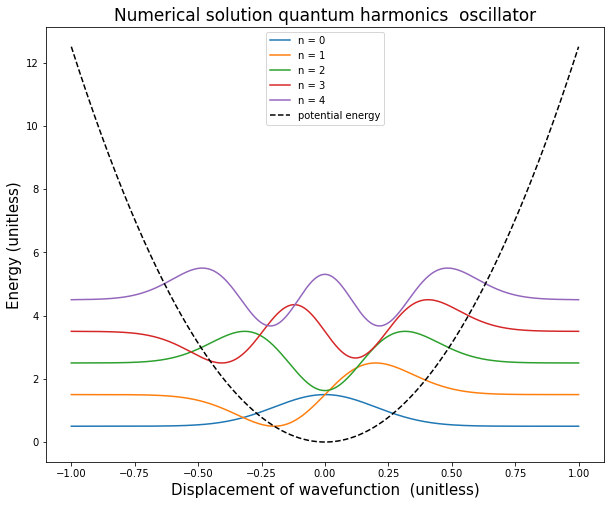

In [239]:
######################
"plot"
######################
fig = plt.figure(figsize=(10, 8))
main_plot = fig.add_subplot(111)
main_plot.set_title("Numerical solution quantum harmonics  oscillator", fontsize="17")
main_plot.set_xlabel("Displacement of wavefunction  (unitless)", fontsize="15")
main_plot.set_ylabel("Energy (unitless)", fontsize="15")
PLOT_LEGEND = [
    "n = 0",
    "n = 1",
    "n = 2",
    "n = 3",
    "n = 4",
    "potential energy"
]

b = 0
for i in eigenValues_List:
    waveFunction_Array = getWaveFunction(i, waveFunctionEmpty_Array)
    # standarize wave function
    waveFunction_Array = waveFunction_Array[1] / np.amax(waveFunction_Array[1])
    # standarize x value
    X_ARRAY = x_array / np.amax(x_array)

    plt.plot(
        X_ARRAY, (-1) ** b * waveFunction_Array + 1 / 2 + b
    )  # conventionally, the right boundary should be positive so that we add a -1
    # when the energy level is odd.
    b += 1
plt.plot(X_ARRAY, potential(x_array), "k--")
plt.legend(PLOT_LEGEND)
plt.show()

Although the shape of the wave function is perfectly correct, we see the adjacent wave function cross each other. The reason is probably that I did not add the physics constants in our calculation to avoid the overflow and floating-point error. Another reason is that the shape of the wave function is highly dependent on the guessed wavefunction values at the second index of the array. Furthermore, the boundary condition for the finite potential wall is vague so it is even harder to determine where the boundary is!
Fortunately, we do not need to care about the plot of the wave function in this section!

<font face="Time New Roman" size=5 color=black >
Reference

1. Ercolessi, F. and de Gironcoli, S., 2022. Numerical Methods in Quantum Mechanics. University of Udine, pp.1-50.

The End. Thanks for reading.